# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [1]:
# Step 1: Install required packages
# If running locally, install these packages in your terminal (not in the notebook):
# pip install torch torchvision einops matplotlib pillow

print("If you haven't already, please install the required packages using pip in your terminal:")
print("pip install torch torchvision einops matplotlib pillow")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU, Apple Silicon, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("We'll be using: cuda (NVIDIA GPU)")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("We'll be using: mps (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("We'll be using: cpu")
    print("Note: Training will be much slower on CPU. Consider using a machine with a GPU (NVIDIA or Apple Silicon) if available.")

# Helper function to move a batch of data to the selected device
def to_device(batch, device):
    if isinstance(batch, (list, tuple)):
        return tuple(x.to(device, non_blocking=True) if hasattr(x, 'to') else x for x in batch)
    elif hasattr(batch, 'to'):
        return batch.to(device, non_blocking=True)
    return batch

# NOTE for Mac users:
# - If you encounter issues with DataLoader, set num_workers=0.
# - You do NOT need pin_memory=True for MPS/CPU.

If you haven't already, please install the required packages using pip in your terminal:
pip install torch torchvision einops matplotlib pillow
We'll be using: mps (Apple Silicon GPU)


In [2]:
import torch
print("MPS available:", torch.backends.mps.is_available())

MPS available: True



###  REPRODUCIBILITY AND DEVICE SETUP

In [3]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you have a GPU, ensure your PyTorch installation supports CUDA.")

Random seeds set to 42 for reproducible results
No GPU detected. Training will be much slower on CPU.
If you have a GPU, ensure your PyTorch installation supports CUDA.


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [4]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# Choose ONE dataset option based on your available GPU memory

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab, basic GPU, or CPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 80

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
print("MNIST dataset loaded successfully.")

#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
"""
IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
# print("Fashion-MNIST dataset loaded successfully.")
"""

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
"""
IMG_SIZE = 32
IMG_CH = 3
N_CLASSES = 10
BATCH_SIZE = 32  # Reduced batch size for memory
EPOCHS = 50      # More epochs for complex data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# print("CIFAR-10 dataset loaded successfully.")
"""

MNIST dataset loaded successfully.


'\nIMG_SIZE = 32\nIMG_CH = 3\nN_CLASSES = 10\nBATCH_SIZE = 32  # Reduced batch size for memory\nEPOCHS = 50      # More epochs for complex data\n\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n])\n\n# dataset = torchvision.datasets.CIFAR10(root=\'./data\', train=True, transform=transform, download=True)\n# print("CIFAR-10 dataset loaded successfully.")\n'

In [5]:
# Validating Dataset Selection
# Let's add code to validate that a dataset was selected and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Validate GPU memory requirements
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # in GB
    print(f"Detected GPU with {gpu_memory:.2f} GB memory.")
    if gpu_memory < 2:
        print("Warning: Less than 2GB GPU memory detected. You may need to reduce batch size.")
else:
    print("No GPU detected. Running on CPU. Training will be slower.")

No GPU detected. Running on CPU. Training will be slower.


In [6]:
# Dataset Properties and Data Loaders
# Now let's examine our dataset and set up the data loaders:

# Check sample batch properties
sample_loader = DataLoader(dataset, batch_size=1)
sample_batch = next(iter(sample_loader))
print(f"Sample batch shape: {sample_batch[0].shape}")
print(f"Sample batch dtype: {sample_batch[0].dtype}")
print(f"Sample batch min: {sample_batch[0].min().item():.2f}")
print(f"Sample batch max: {sample_batch[0].max().item():.2f}")

#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=generator)

# Create dataloaders for training and validation
num_workers = min(4, os.cpu_count() or 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
print(f"Train/val dataloaders created. num_workers={num_workers}")

Sample batch shape: torch.Size([1, 1, 28, 28])
Sample batch dtype: torch.float32
Sample batch min: -1.00
Sample batch max: 1.00
Train/val dataloaders created. num_workers=4


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [7]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0 and group_size > 1:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Create layers for the block
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=group_size, num_channels=out_ch),
            nn.GELU()
        )

    def forward(self, x):
        # Pass the input through the model
        return self.model(x)

In [8]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()
        self.rearrange = Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2)
        self.conv = GELUConvBlock(in_chs * 4, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        x = self.conv(x)
        return x

In [9]:
# Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs (int): Number of input channels from the previous layer
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(2 * in_chs, out_chs, kernel_size=2, stride=2)
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
        print(f"Created UpBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_increase=2x")

    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.upsample(x)
        x = self.conv_blocks(x)
        return x

In [10]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.
    
    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.
    
    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.
        
        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]
            
        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [11]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Create the embedding layers
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.GELU(),
            nn.Unflatten(1, (emb_dim, 1, 1))
        )

    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [12]:
# Downsampling block for encoding path in U-Net architecture
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes features through multiple convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement (RearrangePoolBlock)

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        )
        self.downsample = RearrangePoolBlock(out_chs, group_size)

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.downsample(x)
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Linear(t_embed_dim, t_embed_dim),
            nn.GELU(),
            nn.Unflatten(1, (t_embed_dim, 1, 1))
        )

        # Class embedding
        self.class_embed = EmbedBlock(N_CLASSES, c_embed_dim)

        # Initial convolution
        self.init_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)

        # Downsampling path
        self.down_blocks = nn.ModuleList()
        for i in range(len(down_chs) - 1):
            self.down_blocks.append(DownBlock(down_chs[i], down_chs[i+1], group_size=8))

        # Middle blocks
        self.middle = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8),
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8)
        )

        # Projection layers for time and class embeddings
        self.t_proj = nn.Conv2d(t_embed_dim, down_chs[-1], kernel_size=1)
        self.c_proj = nn.Conv2d(c_embed_dim, down_chs[-1], kernel_size=1)

        # Upsampling path
        self.up_blocks = nn.ModuleList()
        for i in reversed(range(len(down_chs) - 1)):
            self.up_blocks.append(UpBlock(down_chs[i+1], down_chs[i], group_size=8))

        # Final convolution
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        # Time embedding
        t_emb = self.time_embed(t)
        # Class embedding
        c_emb = self.class_embed(c)
        # Project embeddings to match x's channels
        t_emb = self.t_proj(t_emb)
        c_emb = self.c_proj(c_emb)

        # Initial feature extraction
        x = self.init_conv(x)

        # Downsampling path and skip connections
        skips = []
        for down in self.down_blocks:
            x = down(x)
            skips.append(x)

        # Middle processing and conditioning
        x = self.middle(x)
        x = x + t_emb + c_emb * c_mask.unsqueeze(-1).unsqueeze(-1)

        # Upsampling path with skip connections
        for up, skip in zip(self.up_blocks, reversed(skips)):
            x = up(x, skip)

        # Final projection
        x = self.final_conv(x)
        return x

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [14]:
# Set up the noise schedule
n_steps = 500  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.008      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise


In [15]:
# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.
    
    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).
    
    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]
        
    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)
    
    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise

    return x_t, noise

In [16]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.
    
    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.
    
    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]
        
    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)
    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )
        
        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)
        
        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise

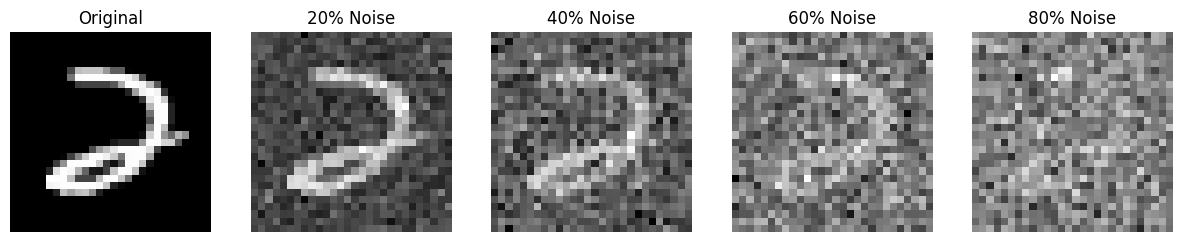

'\n# Try a non-linear noise schedule\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n# How would this affect the diffusion process?\n'

In [17]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.
    
    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)
        
        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/num_steps) * 100)}% Noise')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_dataloader))  # Get first batch
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
# Uncomment and modify these lines to experiment:
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
# How would this affect the diffusion process?
"""

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [18]:
# ------------------------------------------------------------------------------
# CREATE OUR MAIN MODEL AND MOVE IT TO THE GPU IF AVAILABLE (UPDATED)
# ------------------------------------------------------------------------------

model = UNet(
    T=n_steps,              # Number of diffusion time steps
    img_ch=IMG_CH,          # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,      # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(32, 64, 128), # Channel dimensions for each downsampling level
    t_embed_dim=8,          # Dimension for time step embeddings
    c_embed_dim=64          # <--- INCREASED from N_CLASSES to 64
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
def validate_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.
    
    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

validate_model_parameters(model)

# Your code to verify data ranges and integrity
def verify_data_range(dataloader, name="Dataset"):
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

verify_data_range(train_dataloader, "Train")
verify_data_range(val_dataloader, "Validation")

# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.0002  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(), 
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',    # Reduce LR when monitored value stops decreasing
    factor=0.5,    # Multiply LR by this factor
    patience=5,    # Number of epochs with no improvement after which LR will be reduced
    verbose=True,  # Print message when LR is reduced
    min_lr=1e-6    # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
#  1. Model size (parameter count)
#  2. Training time
#  3. Generated image quality
#
# Suggestions:
#  - Smaller: down_chs=(16, 32, 64)
#  - Larger: down_chs=(64, 128, 256, 512)

Created UpBlock: in_chs=128, out_chs=64, spatial_increase=2x
Created UpBlock: in_chs=64, out_chs=32, spatial_increase=2x
Created UNet with 3 scale levels
Channel dimensions: (32, 64, 128)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 500
Condition classes: 10
GPU acceleration: No
Total parameters: 1,500,817
Trainable parameters: 1,500,817
Estimated GPU memory usage: 22.9 MB

Train range check:
Shape: torch.Size([64, 1, 28, 28])
Data type: torch.float32
Min value: -1.00
Max value: 1.00
Contains NaN: False
Contains Inf: False

Validation range check:
Shape: torch.Size([64, 1, 28, 28])
Data type: torch.float32
Min value: -1.00
Max value: 1.00
Contains NaN: False
Contains Inf: False


/Users/martin.demel/myenv3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.
    
    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)
            
            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)
            
            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)
            
            samples.append(x)
            
        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)
        
        plt.figure(figsize=(10, 4))
        
        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())
        
        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()
        
# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }
        
        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss
            
        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")
        
        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")
        
    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")
        
        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

In [20]:
#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.
    
    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise
    
    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]
        
    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
    
    # Create conditioning mask (all ones for standard training)
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    x_t, noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    loss = F.mse_loss(predicted_noise, noise)
    return loss

Created UpBlock: in_chs=128, out_chs=64, spatial_increase=2x
Created UpBlock: in_chs=64, out_chs=32, spatial_increase=2x
Created UNet with 3 scale levels
Channel dimensions: (32, 64, 128)

STARTING TRAINING (WITH EMA)

Epoch 1/50
--------------------
  Step 0/750, Loss: 1.3832
  Step 100/750, Loss: 0.1395
  Step 200/750, Loss: 0.1277
  Step 300/750, Loss: 0.0987
  Step 400/750, Loss: 0.0838
  Step 500/750, Loss: 0.0994
  Generating samples (EMA model)...


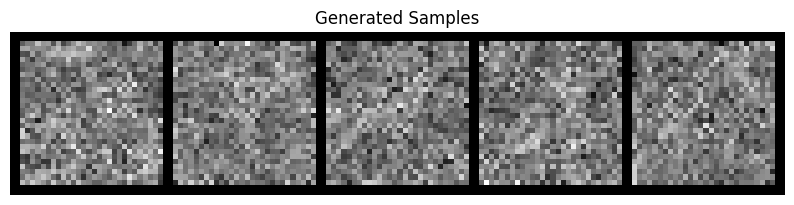

  Step 600/750, Loss: 0.0876
  Step 700/750, Loss: 0.0897

Training - Epoch 1 average loss: 0.1249
Running validation...
Validation - Epoch 1 average loss: 0.0791
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


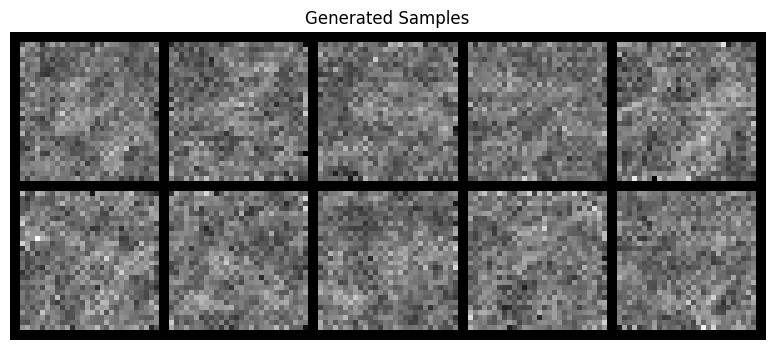

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0791)

Epoch 2/50
--------------------
  Step 0/750, Loss: 0.0757
  Step 100/750, Loss: 0.0791
  Step 200/750, Loss: 0.0771
  Step 300/750, Loss: 0.0682
  Step 400/750, Loss: 0.0668
  Step 500/750, Loss: 0.0550
  Generating samples (EMA model)...


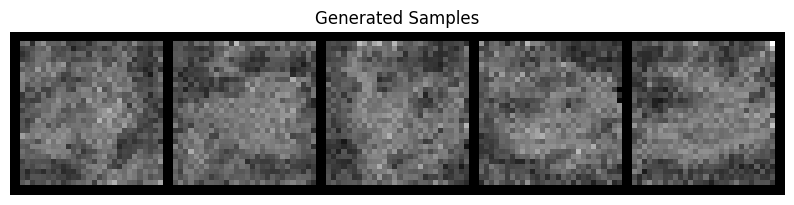

  Step 600/750, Loss: 0.0652
  Step 700/750, Loss: 0.0606

Training - Epoch 2 average loss: 0.0718
Running validation...
Validation - Epoch 2 average loss: 0.0667
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0667)

Epoch 3/50
--------------------
  Step 0/750, Loss: 0.0702
  Step 100/750, Loss: 0.0550
  Step 200/750, Loss: 0.0601
  Step 300/750, Loss: 0.0574
  Step 400/750, Loss: 0.0784
  Step 500/750, Loss: 0.0604
  Generating samples (EMA model)...


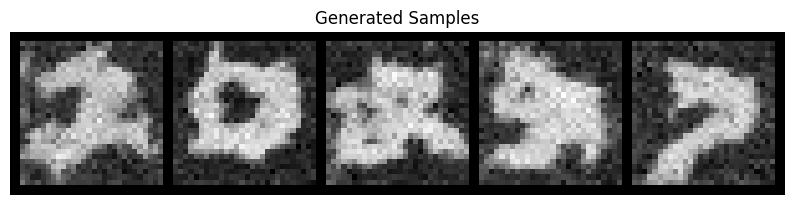

  Step 600/750, Loss: 0.0602
  Step 700/750, Loss: 0.0537

Training - Epoch 3 average loss: 0.0644
Running validation...
Validation - Epoch 3 average loss: 0.0635
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


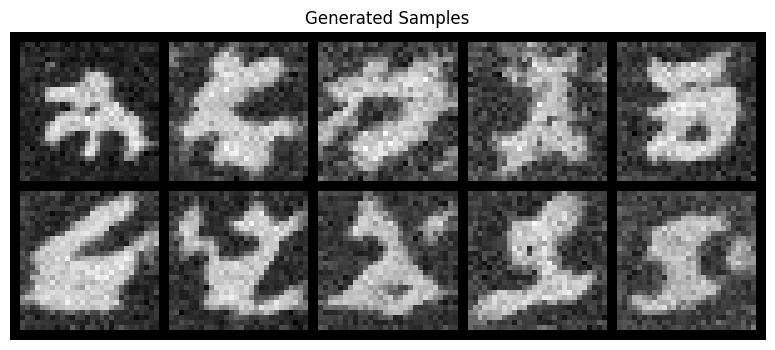

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0635)

Epoch 4/50
--------------------
  Step 0/750, Loss: 0.0588
  Step 100/750, Loss: 0.0613
  Step 200/750, Loss: 0.0654
  Step 300/750, Loss: 0.0560
  Step 400/750, Loss: 0.0669
  Step 500/750, Loss: 0.0534
  Generating samples (EMA model)...


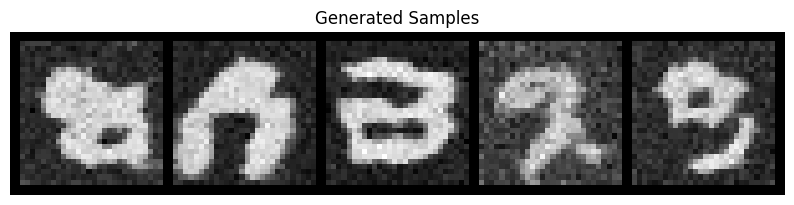

  Step 600/750, Loss: 0.0542
  Step 700/750, Loss: 0.0576

Training - Epoch 4 average loss: 0.0611
Running validation...
Validation - Epoch 4 average loss: 0.0603
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0603)

Epoch 5/50
--------------------
  Step 0/750, Loss: 0.0591
  Step 100/750, Loss: 0.0527
  Step 200/750, Loss: 0.0564
  Step 300/750, Loss: 0.0504
  Step 400/750, Loss: 0.0611
  Step 500/750, Loss: 0.0612
  Generating samples (EMA model)...


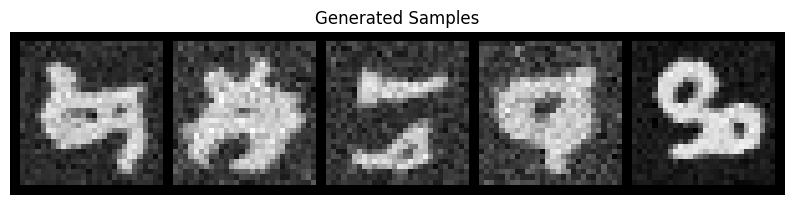

  Step 600/750, Loss: 0.0491
  Step 700/750, Loss: 0.0606

Training - Epoch 5 average loss: 0.0586
Running validation...
Validation - Epoch 5 average loss: 0.0571
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


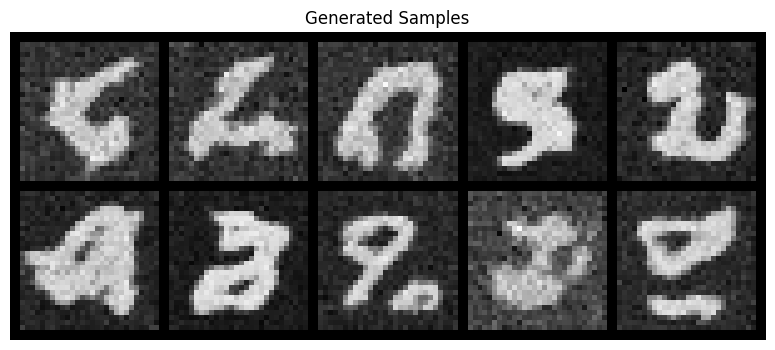

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0571)

Epoch 6/50
--------------------
  Step 0/750, Loss: 0.0529
  Step 100/750, Loss: 0.0497
  Step 200/750, Loss: 0.0543
  Step 300/750, Loss: 0.0615
  Step 400/750, Loss: 0.0588
  Step 500/750, Loss: 0.0626
  Generating samples (EMA model)...


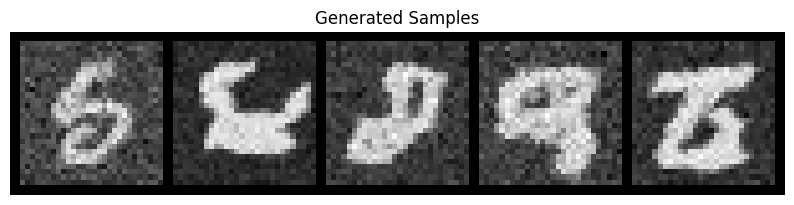

  Step 600/750, Loss: 0.0597
  Step 700/750, Loss: 0.0480

Training - Epoch 6 average loss: 0.0567
Running validation...
Validation - Epoch 6 average loss: 0.0547
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0547)

Epoch 7/50
--------------------
  Step 0/750, Loss: 0.0610
  Step 100/750, Loss: 0.0508
  Step 200/750, Loss: 0.0547
  Step 300/750, Loss: 0.0536
  Step 400/750, Loss: 0.0757
  Step 500/750, Loss: 0.0590
  Generating samples (EMA model)...


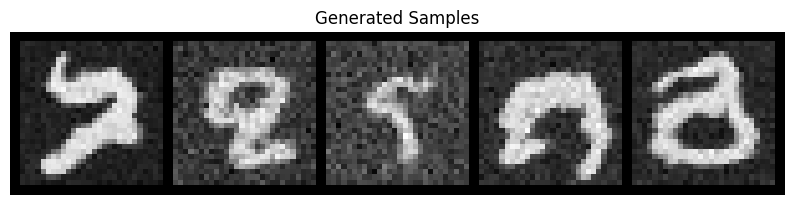

  Step 600/750, Loss: 0.0541
  Step 700/750, Loss: 0.0575

Training - Epoch 7 average loss: 0.0555
Running validation...
Validation - Epoch 7 average loss: 0.0539
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


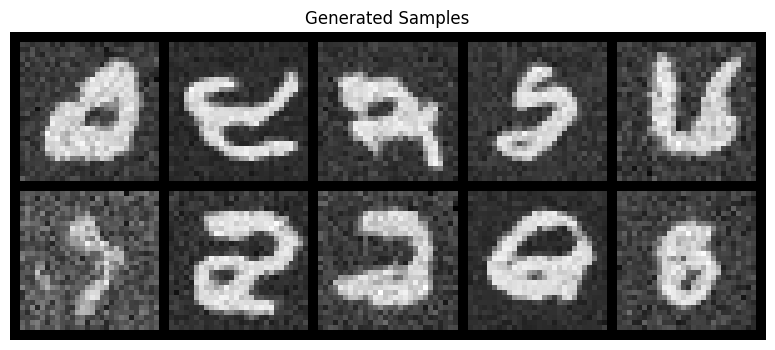

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0539)

Epoch 8/50
--------------------
  Step 0/750, Loss: 0.0517
  Step 100/750, Loss: 0.0538
  Step 200/750, Loss: 0.0637
  Step 300/750, Loss: 0.0467
  Step 400/750, Loss: 0.0491
  Step 500/750, Loss: 0.0563
  Generating samples (EMA model)...


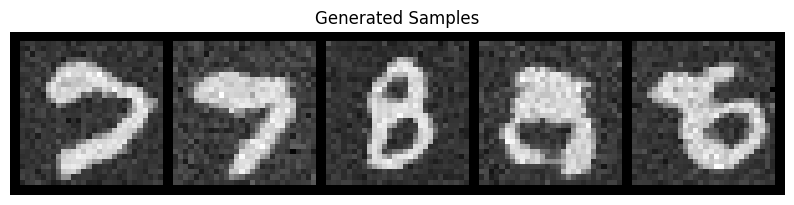

  Step 600/750, Loss: 0.0588
  Step 700/750, Loss: 0.0531

Training - Epoch 8 average loss: 0.0538
Running validation...
Validation - Epoch 8 average loss: 0.0531
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0531)

Epoch 9/50
--------------------
  Step 0/750, Loss: 0.0638
  Step 100/750, Loss: 0.0566
  Step 200/750, Loss: 0.0507
  Step 300/750, Loss: 0.0482
  Step 400/750, Loss: 0.0549
  Step 500/750, Loss: 0.0496
  Generating samples (EMA model)...


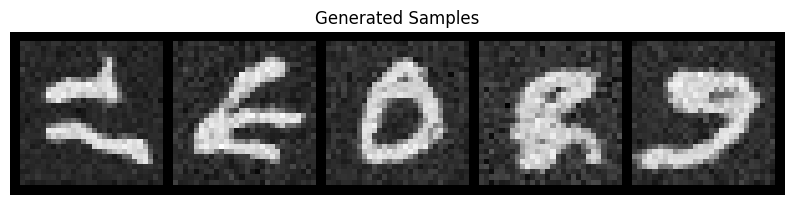

  Step 600/750, Loss: 0.0467
  Step 700/750, Loss: 0.0510

Training - Epoch 9 average loss: 0.0527
Running validation...
Validation - Epoch 9 average loss: 0.0533
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


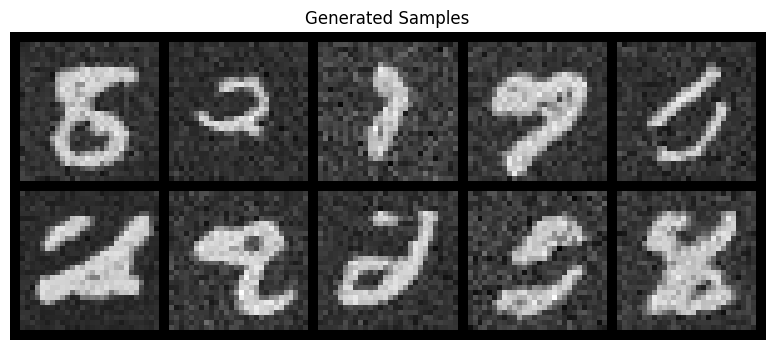

No improvement for 1/10 epochs

Epoch 10/50
--------------------
  Step 0/750, Loss: 0.0469
  Step 100/750, Loss: 0.0519
  Step 200/750, Loss: 0.0572
  Step 300/750, Loss: 0.0494
  Step 400/750, Loss: 0.0529
  Step 500/750, Loss: 0.0483
  Generating samples (EMA model)...


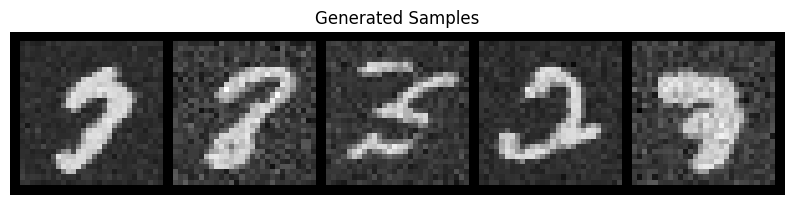

  Step 600/750, Loss: 0.0437
  Step 700/750, Loss: 0.0548

Training - Epoch 10 average loss: 0.0524
Running validation...
Validation - Epoch 10 average loss: 0.0517
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0517)

Epoch 11/50
--------------------
  Step 0/750, Loss: 0.0500
  Step 100/750, Loss: 0.0553
  Step 200/750, Loss: 0.0495
  Step 300/750, Loss: 0.0542
  Step 400/750, Loss: 0.0469
  Step 500/750, Loss: 0.0565
  Generating samples (EMA model)...


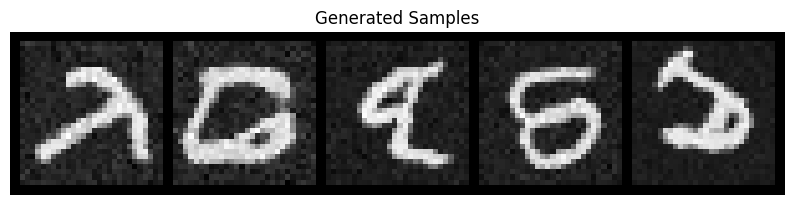

  Step 600/750, Loss: 0.0597
  Step 700/750, Loss: 0.0514

Training - Epoch 11 average loss: 0.0515
Running validation...
Validation - Epoch 11 average loss: 0.0517
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


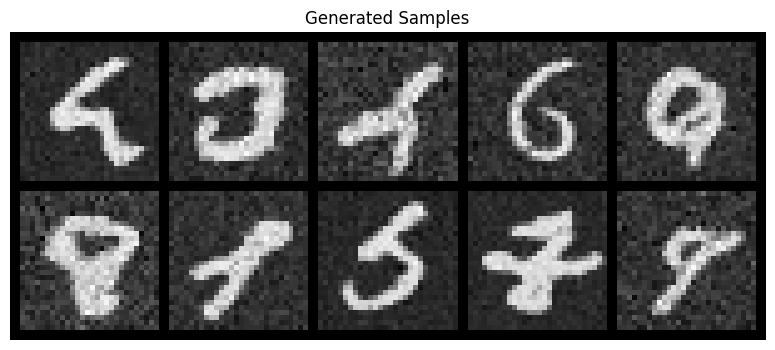

No improvement for 1/10 epochs

Epoch 12/50
--------------------
  Step 0/750, Loss: 0.0485
  Step 100/750, Loss: 0.0536
  Step 200/750, Loss: 0.0430
  Step 300/750, Loss: 0.0494
  Step 400/750, Loss: 0.0527
  Step 500/750, Loss: 0.0476
  Generating samples (EMA model)...


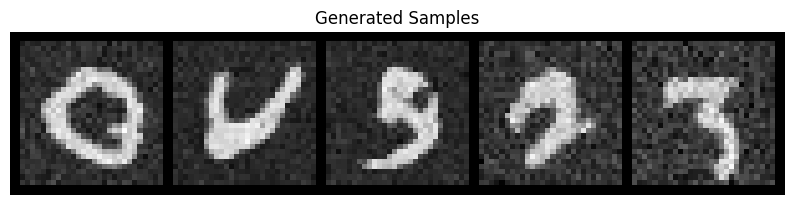

  Step 600/750, Loss: 0.0517
  Step 700/750, Loss: 0.0467

Training - Epoch 12 average loss: 0.0512
Running validation...
Validation - Epoch 12 average loss: 0.0500
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0500)

Epoch 13/50
--------------------
  Step 0/750, Loss: 0.0579
  Step 100/750, Loss: 0.0537
  Step 200/750, Loss: 0.0591
  Step 300/750, Loss: 0.0492
  Step 400/750, Loss: 0.0511
  Step 500/750, Loss: 0.0561
  Generating samples (EMA model)...


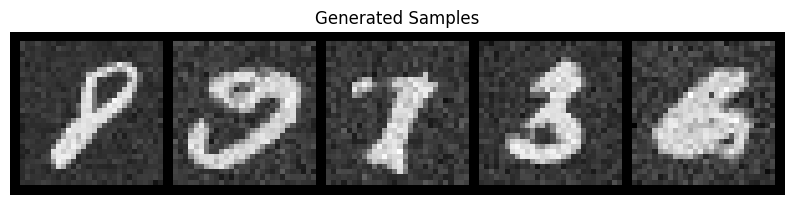

  Step 600/750, Loss: 0.0519
  Step 700/750, Loss: 0.0511

Training - Epoch 13 average loss: 0.0510
Running validation...
Validation - Epoch 13 average loss: 0.0509
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


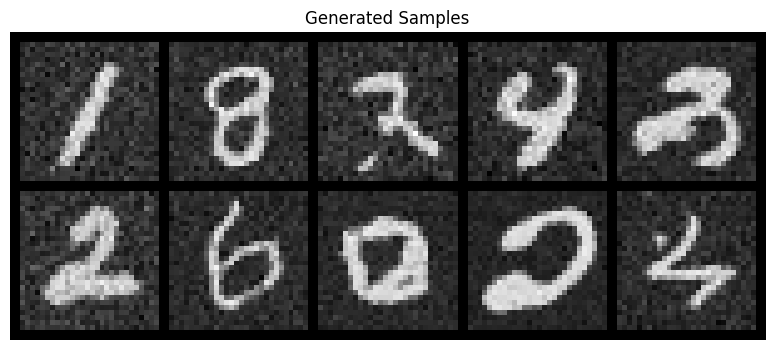

No improvement for 1/10 epochs

Epoch 14/50
--------------------
  Step 0/750, Loss: 0.0433
  Step 100/750, Loss: 0.0432
  Step 200/750, Loss: 0.0465
  Step 300/750, Loss: 0.0471
  Step 400/750, Loss: 0.0560
  Step 500/750, Loss: 0.0483
  Generating samples (EMA model)...


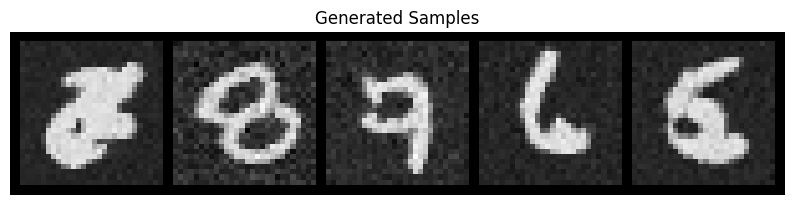

  Step 600/750, Loss: 0.0535
  Step 700/750, Loss: 0.0601

Training - Epoch 14 average loss: 0.0505
Running validation...
Validation - Epoch 14 average loss: 0.0498
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0498)

Epoch 15/50
--------------------
  Step 0/750, Loss: 0.0444
  Step 100/750, Loss: 0.0479
  Step 200/750, Loss: 0.0545
  Step 300/750, Loss: 0.0550
  Step 400/750, Loss: 0.0500
  Step 500/750, Loss: 0.0489
  Generating samples (EMA model)...


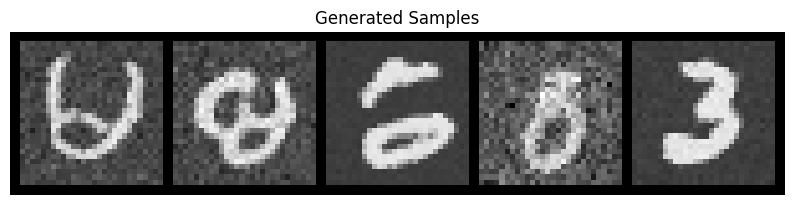

  Step 600/750, Loss: 0.0543
  Step 700/750, Loss: 0.0473

Training - Epoch 15 average loss: 0.0501
Running validation...
Validation - Epoch 15 average loss: 0.0503
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


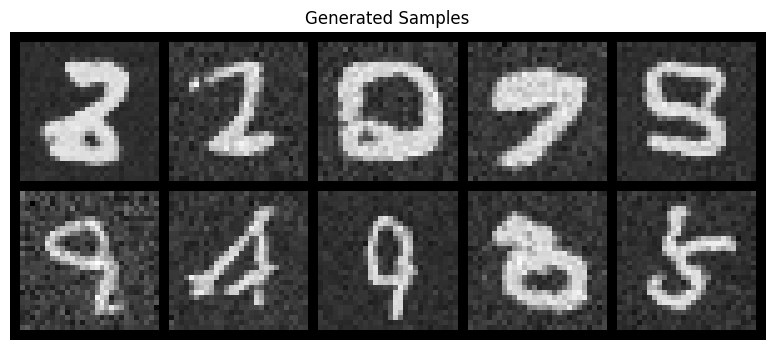

No improvement for 1/10 epochs

Epoch 16/50
--------------------
  Step 0/750, Loss: 0.0510
  Step 100/750, Loss: 0.0559
  Step 200/750, Loss: 0.0498
  Step 300/750, Loss: 0.0489
  Step 400/750, Loss: 0.0533
  Step 500/750, Loss: 0.0622
  Generating samples (EMA model)...


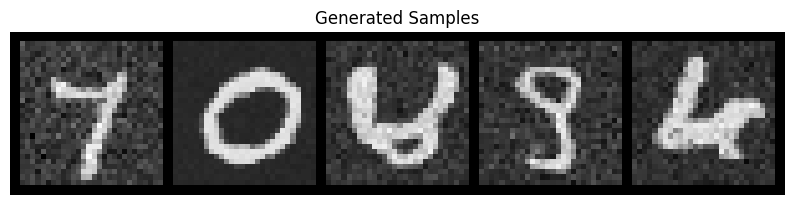

  Step 600/750, Loss: 0.0450
  Step 700/750, Loss: 0.0488

Training - Epoch 16 average loss: 0.0499
Running validation...
Validation - Epoch 16 average loss: 0.0495
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0495)

Epoch 17/50
--------------------
  Step 0/750, Loss: 0.0494
  Step 100/750, Loss: 0.0492
  Step 200/750, Loss: 0.0500
  Step 300/750, Loss: 0.0526
  Step 400/750, Loss: 0.0397
  Step 500/750, Loss: 0.0487
  Generating samples (EMA model)...


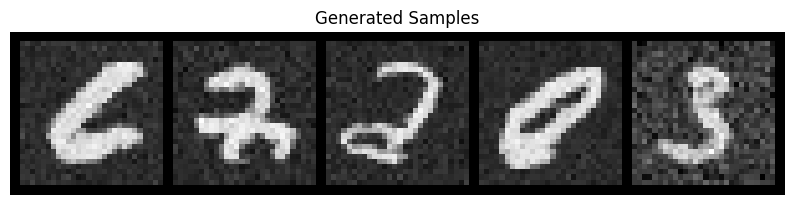

  Step 600/750, Loss: 0.0508
  Step 700/750, Loss: 0.0512

Training - Epoch 17 average loss: 0.0494
Running validation...
Validation - Epoch 17 average loss: 0.0481
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


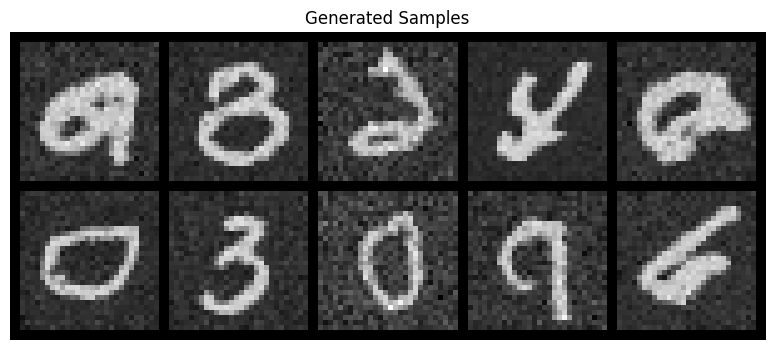

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0481)

Epoch 18/50
--------------------
  Step 0/750, Loss: 0.0459
  Step 100/750, Loss: 0.0471
  Step 200/750, Loss: 0.0486
  Step 300/750, Loss: 0.0498
  Step 400/750, Loss: 0.0494
  Step 500/750, Loss: 0.0529
  Generating samples (EMA model)...


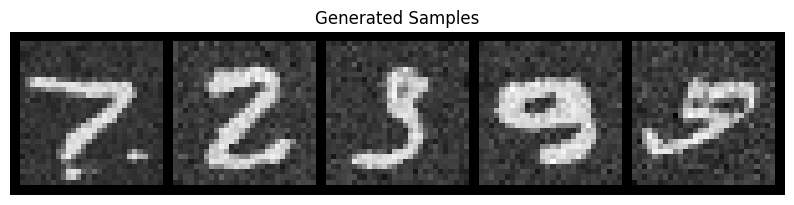

  Step 600/750, Loss: 0.0565
  Step 700/750, Loss: 0.0517

Training - Epoch 18 average loss: 0.0490
Running validation...
Validation - Epoch 18 average loss: 0.0487
Learning rate: 0.000200
No improvement for 1/10 epochs

Epoch 19/50
--------------------
  Step 0/750, Loss: 0.0460
  Step 100/750, Loss: 0.0438
  Step 200/750, Loss: 0.0467
  Step 300/750, Loss: 0.0516
  Step 400/750, Loss: 0.0510
  Step 500/750, Loss: 0.0559
  Generating samples (EMA model)...


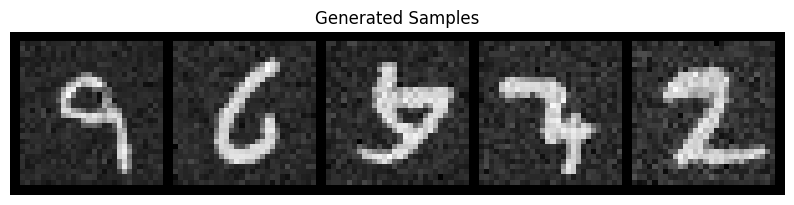

  Step 600/750, Loss: 0.0500
  Step 700/750, Loss: 0.0537

Training - Epoch 19 average loss: 0.0488
Running validation...
Validation - Epoch 19 average loss: 0.0491
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


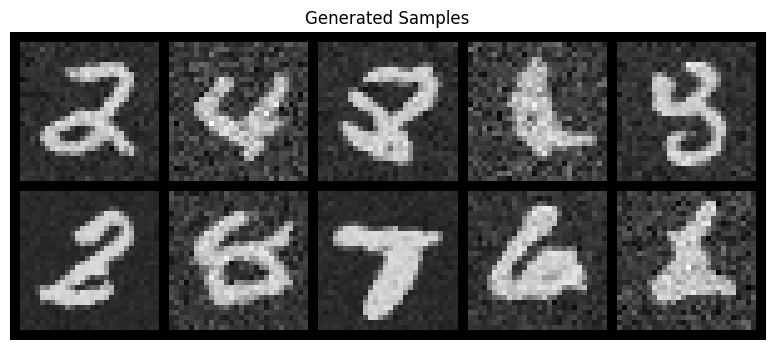

No improvement for 2/10 epochs

Epoch 20/50
--------------------
  Step 0/750, Loss: 0.0570
  Step 100/750, Loss: 0.0457
  Step 200/750, Loss: 0.0535
  Step 300/750, Loss: 0.0483
  Step 400/750, Loss: 0.0467
  Step 500/750, Loss: 0.0469
  Generating samples (EMA model)...


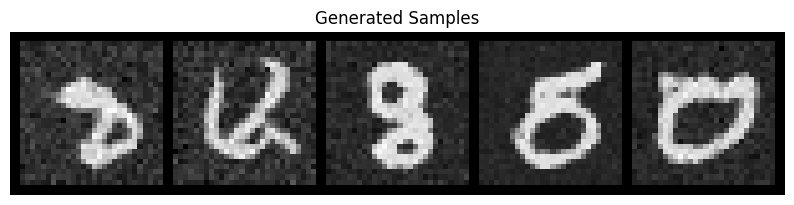

  Step 600/750, Loss: 0.0466
  Step 700/750, Loss: 0.0471

Training - Epoch 20 average loss: 0.0489
Running validation...
Validation - Epoch 20 average loss: 0.0485
Learning rate: 0.000200
No improvement for 3/10 epochs

Epoch 21/50
--------------------
  Step 0/750, Loss: 0.0474
  Step 100/750, Loss: 0.0447
  Step 200/750, Loss: 0.0506
  Step 300/750, Loss: 0.0479
  Step 400/750, Loss: 0.0487
  Step 500/750, Loss: 0.0495
  Generating samples (EMA model)...


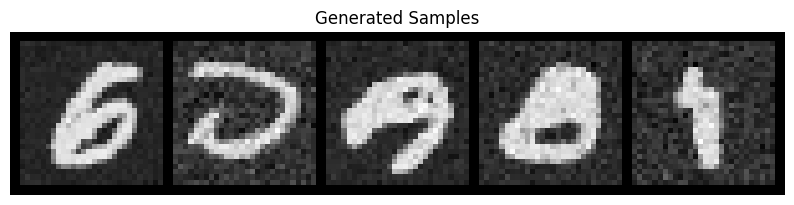

  Step 600/750, Loss: 0.0532
  Step 700/750, Loss: 0.0486

Training - Epoch 21 average loss: 0.0486
Running validation...
Validation - Epoch 21 average loss: 0.0484
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


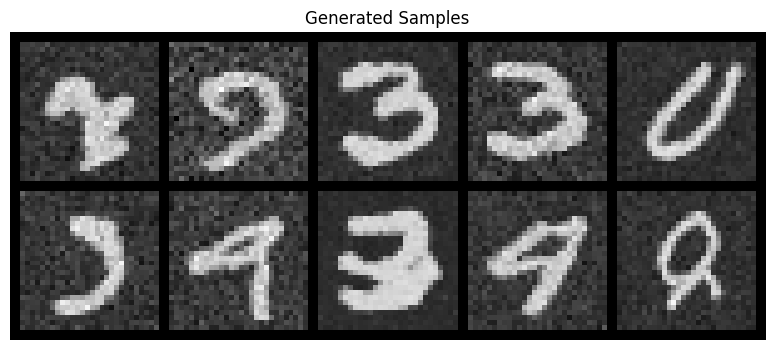

No improvement for 4/10 epochs

Epoch 22/50
--------------------
  Step 0/750, Loss: 0.0609
  Step 100/750, Loss: 0.0390
  Step 200/750, Loss: 0.0578
  Step 300/750, Loss: 0.0497
  Step 400/750, Loss: 0.0507
  Step 500/750, Loss: 0.0478
  Generating samples (EMA model)...


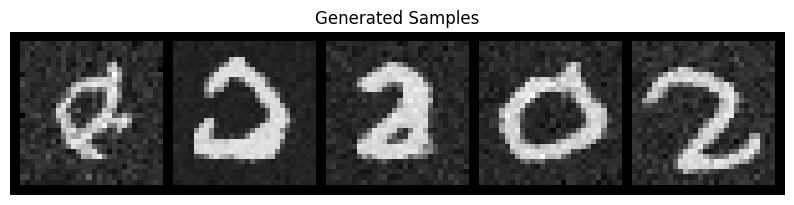

  Step 600/750, Loss: 0.0477
  Step 700/750, Loss: 0.0490

Training - Epoch 22 average loss: 0.0483
Running validation...
Validation - Epoch 22 average loss: 0.0483
Learning rate: 0.000200
No improvement for 5/10 epochs

Epoch 23/50
--------------------
  Step 0/750, Loss: 0.0571
  Step 100/750, Loss: 0.0467
  Step 200/750, Loss: 0.0481
  Step 300/750, Loss: 0.0519
  Step 400/750, Loss: 0.0525
  Step 500/750, Loss: 0.0480
  Generating samples (EMA model)...


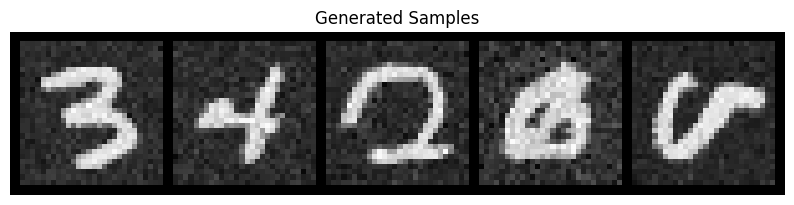

  Step 600/750, Loss: 0.0471
  Step 700/750, Loss: 0.0502

Training - Epoch 23 average loss: 0.0485
Running validation...
Validation - Epoch 23 average loss: 0.0478
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


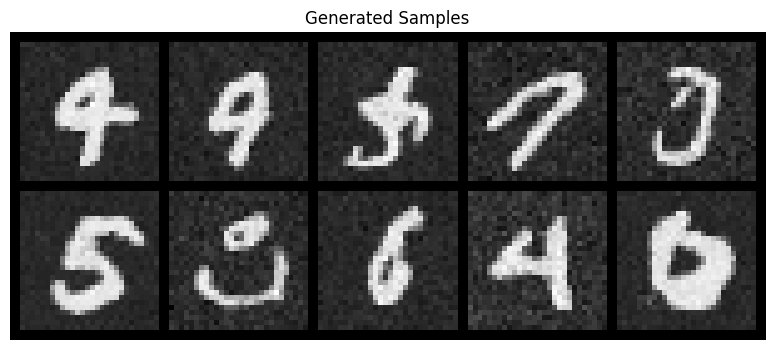

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0478)

Epoch 24/50
--------------------
  Step 0/750, Loss: 0.0483
  Step 100/750, Loss: 0.0539
  Step 200/750, Loss: 0.0500
  Step 300/750, Loss: 0.0404
  Step 400/750, Loss: 0.0535
  Step 500/750, Loss: 0.0469
  Generating samples (EMA model)...


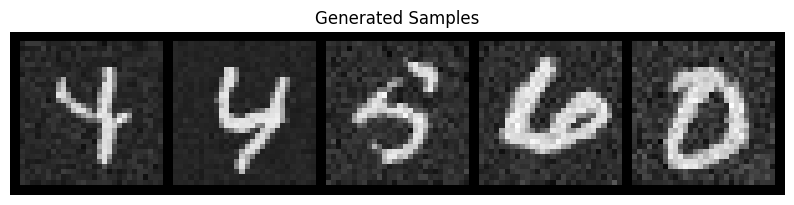

  Step 600/750, Loss: 0.0489
  Step 700/750, Loss: 0.0477

Training - Epoch 24 average loss: 0.0484
Running validation...
Validation - Epoch 24 average loss: 0.0473
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0473)

Epoch 25/50
--------------------
  Step 0/750, Loss: 0.0499
  Step 100/750, Loss: 0.0475
  Step 200/750, Loss: 0.0457
  Step 300/750, Loss: 0.0497
  Step 400/750, Loss: 0.0472
  Step 500/750, Loss: 0.0508
  Generating samples (EMA model)...


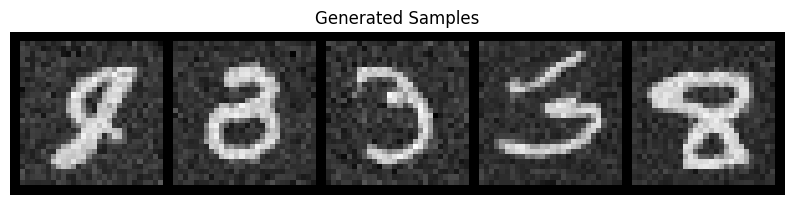

  Step 600/750, Loss: 0.0490
  Step 700/750, Loss: 0.0480

Training - Epoch 25 average loss: 0.0478
Running validation...
Validation - Epoch 25 average loss: 0.0485
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


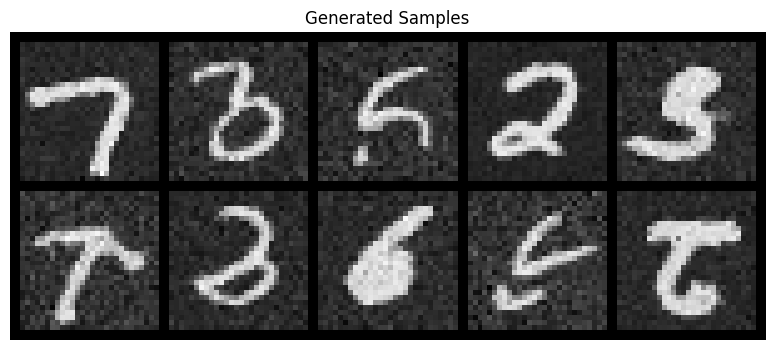

No improvement for 1/10 epochs

Epoch 26/50
--------------------
  Step 0/750, Loss: 0.0483
  Step 100/750, Loss: 0.0504
  Step 200/750, Loss: 0.0425
  Step 300/750, Loss: 0.0440
  Step 400/750, Loss: 0.0459
  Step 500/750, Loss: 0.0491
  Generating samples (EMA model)...


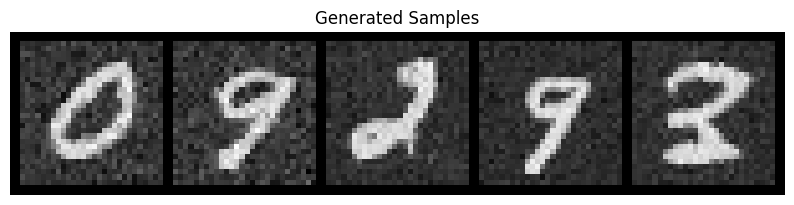

  Step 600/750, Loss: 0.0444
  Step 700/750, Loss: 0.0457

Training - Epoch 26 average loss: 0.0479
Running validation...
Validation - Epoch 26 average loss: 0.0476
Learning rate: 0.000200
No improvement for 2/10 epochs

Epoch 27/50
--------------------
  Step 0/750, Loss: 0.0428
  Step 100/750, Loss: 0.0568
  Step 200/750, Loss: 0.0584
  Step 300/750, Loss: 0.0460
  Step 400/750, Loss: 0.0428
  Step 500/750, Loss: 0.0463
  Generating samples (EMA model)...


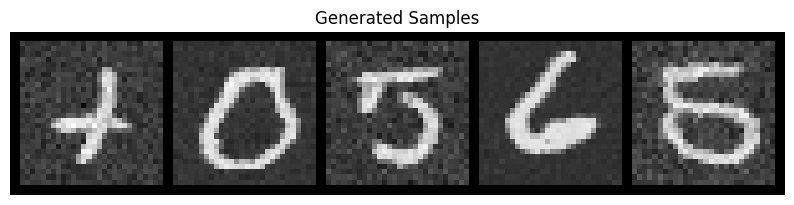

  Step 600/750, Loss: 0.0536
  Step 700/750, Loss: 0.0503

Training - Epoch 27 average loss: 0.0479
Running validation...
Validation - Epoch 27 average loss: 0.0474
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


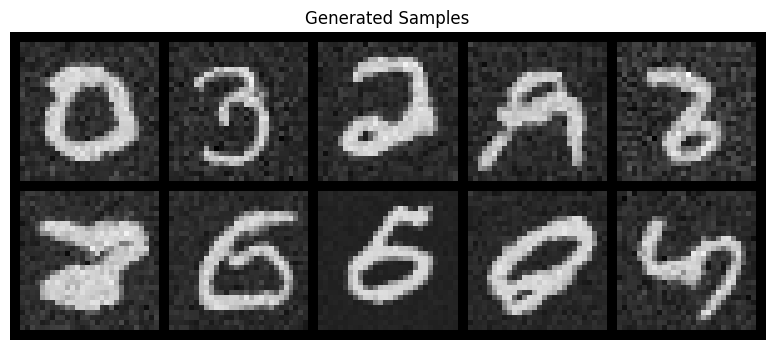

No improvement for 3/10 epochs

Epoch 28/50
--------------------
  Step 0/750, Loss: 0.0506
  Step 100/750, Loss: 0.0436
  Step 200/750, Loss: 0.0417
  Step 300/750, Loss: 0.0471
  Step 400/750, Loss: 0.0460
  Step 500/750, Loss: 0.0513
  Generating samples (EMA model)...


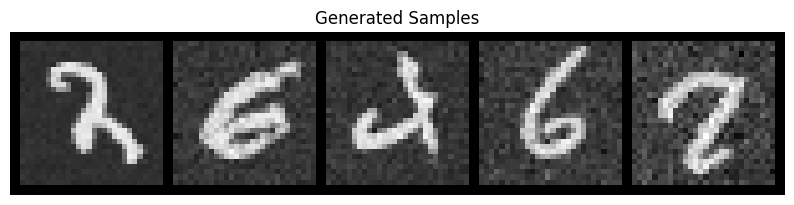

  Step 600/750, Loss: 0.0450
  Step 700/750, Loss: 0.0481

Training - Epoch 28 average loss: 0.0474
Running validation...
Validation - Epoch 28 average loss: 0.0468
Learning rate: 0.000200
Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0468)

Epoch 29/50
--------------------
  Step 0/750, Loss: 0.0456
  Step 100/750, Loss: 0.0438
  Step 200/750, Loss: 0.0409
  Step 300/750, Loss: 0.0454
  Step 400/750, Loss: 0.0519
  Step 500/750, Loss: 0.0493
  Generating samples (EMA model)...


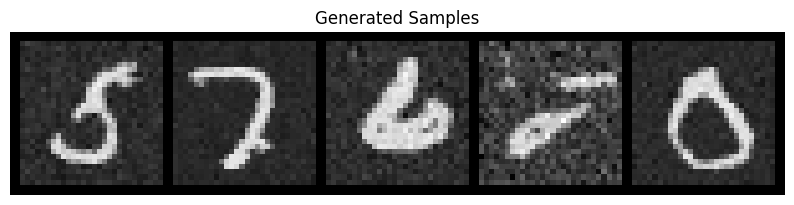

  Step 600/750, Loss: 0.0535
  Step 700/750, Loss: 0.0554

Training - Epoch 29 average loss: 0.0474
Running validation...
Validation - Epoch 29 average loss: 0.0476
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


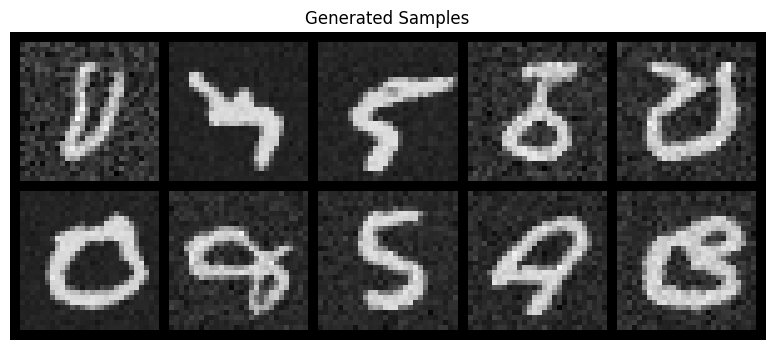

No improvement for 1/10 epochs

Epoch 30/50
--------------------
  Step 0/750, Loss: 0.0414
  Step 100/750, Loss: 0.0549
  Step 200/750, Loss: 0.0467
  Step 300/750, Loss: 0.0498
  Step 400/750, Loss: 0.0509
  Step 500/750, Loss: 0.0492
  Generating samples (EMA model)...


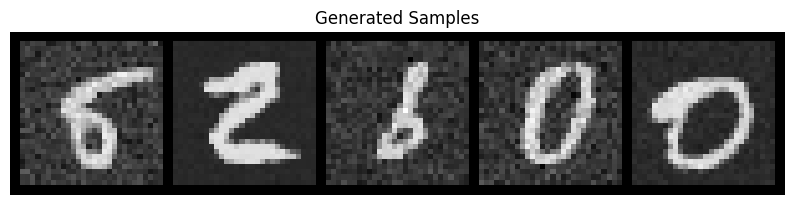

  Step 600/750, Loss: 0.0528
  Step 700/750, Loss: 0.0471

Training - Epoch 30 average loss: 0.0475
Running validation...
Validation - Epoch 30 average loss: 0.0478
Learning rate: 0.000200
No improvement for 2/10 epochs

Epoch 31/50
--------------------
  Step 0/750, Loss: 0.0542
  Step 100/750, Loss: 0.0499
  Step 200/750, Loss: 0.0551
  Step 300/750, Loss: 0.0526
  Step 400/750, Loss: 0.0499
  Step 500/750, Loss: 0.0538
  Generating samples (EMA model)...


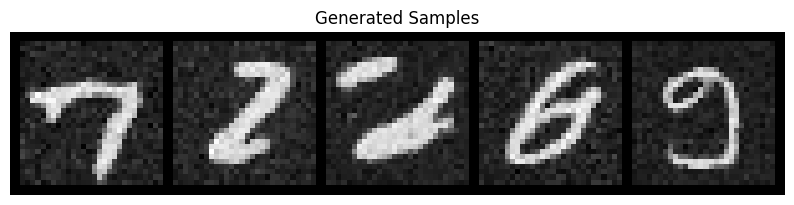

  Step 600/750, Loss: 0.0498
  Step 700/750, Loss: 0.0390

Training - Epoch 31 average loss: 0.0473
Running validation...
Validation - Epoch 31 average loss: 0.0473
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


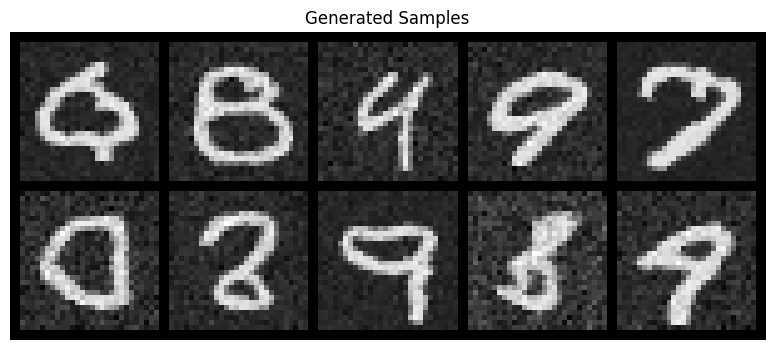

No improvement for 3/10 epochs

Epoch 32/50
--------------------
  Step 0/750, Loss: 0.0545
  Step 100/750, Loss: 0.0565
  Step 200/750, Loss: 0.0526
  Step 300/750, Loss: 0.0464
  Step 400/750, Loss: 0.0464
  Step 500/750, Loss: 0.0489
  Generating samples (EMA model)...


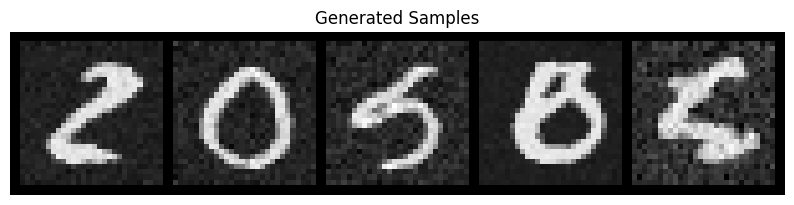

  Step 600/750, Loss: 0.0416
  Step 700/750, Loss: 0.0525

Training - Epoch 32 average loss: 0.0471
Running validation...
Validation - Epoch 32 average loss: 0.0471
Learning rate: 0.000200
No improvement for 4/10 epochs

Epoch 33/50
--------------------
  Step 0/750, Loss: 0.0456
  Step 100/750, Loss: 0.0518
  Step 200/750, Loss: 0.0475
  Step 300/750, Loss: 0.0487
  Step 400/750, Loss: 0.0488
  Step 500/750, Loss: 0.0485
  Generating samples (EMA model)...


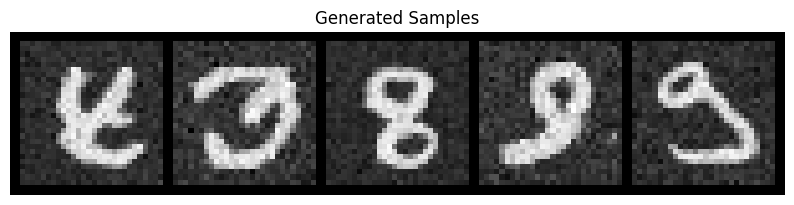

  Step 600/750, Loss: 0.0455
  Step 700/750, Loss: 0.0422

Training - Epoch 33 average loss: 0.0472
Running validation...
Validation - Epoch 33 average loss: 0.0474
Learning rate: 0.000200

Generating samples for visual progress check (EMA model)...


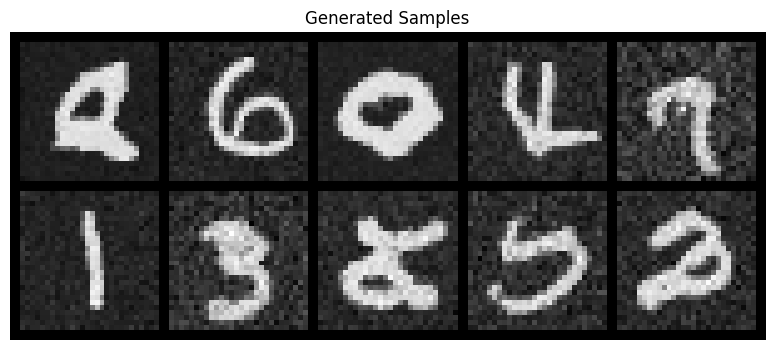

No improvement for 5/10 epochs

Epoch 34/50
--------------------
  Step 0/750, Loss: 0.0505
  Step 100/750, Loss: 0.0491
  Step 200/750, Loss: 0.0462
  Step 300/750, Loss: 0.0466
  Step 400/750, Loss: 0.0393
  Step 500/750, Loss: 0.0432
  Generating samples (EMA model)...


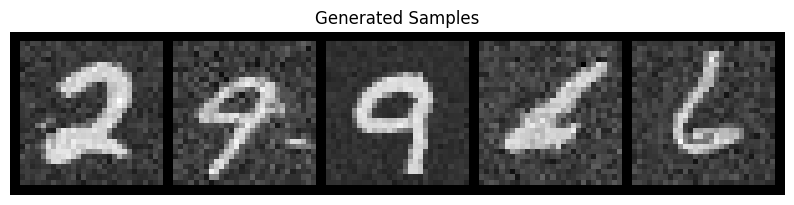

  Step 600/750, Loss: 0.0398
  Step 700/750, Loss: 0.0414

Training - Epoch 34 average loss: 0.0470
Running validation...
Validation - Epoch 34 average loss: 0.0470
Learning rate: 0.000100
No improvement for 6/10 epochs

Epoch 35/50
--------------------
  Step 0/750, Loss: 0.0450
  Step 100/750, Loss: 0.0449
  Step 200/750, Loss: 0.0454
  Step 300/750, Loss: 0.0460
  Step 400/750, Loss: 0.0469
  Step 500/750, Loss: 0.0447
  Generating samples (EMA model)...


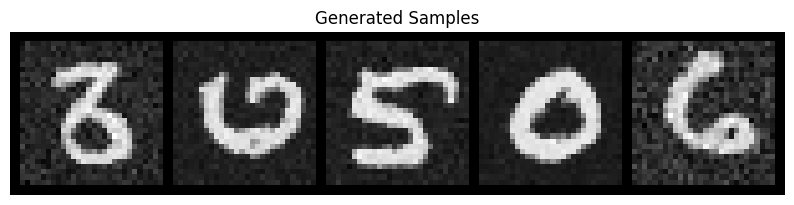

  Step 600/750, Loss: 0.0434
  Step 700/750, Loss: 0.0381

Training - Epoch 35 average loss: 0.0460
Running validation...
Validation - Epoch 35 average loss: 0.0458
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


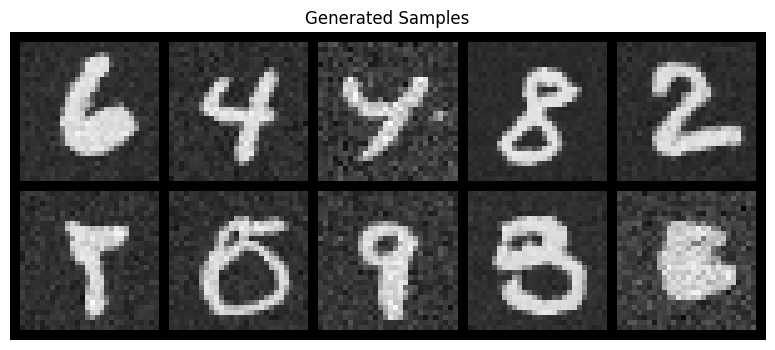

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0458)

Epoch 36/50
--------------------
  Step 0/750, Loss: 0.0453
  Step 100/750, Loss: 0.0425
  Step 200/750, Loss: 0.0469
  Step 300/750, Loss: 0.0458
  Step 400/750, Loss: 0.0391
  Step 500/750, Loss: 0.0463
  Generating samples (EMA model)...


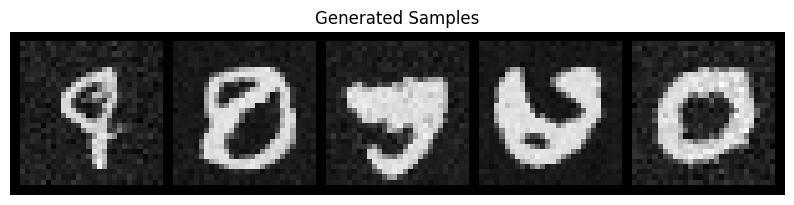

  Step 600/750, Loss: 0.0400
  Step 700/750, Loss: 0.0389

Training - Epoch 36 average loss: 0.0458
Running validation...
Validation - Epoch 36 average loss: 0.0463
Learning rate: 0.000100
No improvement for 1/10 epochs

Epoch 37/50
--------------------
  Step 0/750, Loss: 0.0447
  Step 100/750, Loss: 0.0408
  Step 200/750, Loss: 0.0385
  Step 300/750, Loss: 0.0539
  Step 400/750, Loss: 0.0441
  Step 500/750, Loss: 0.0522
  Generating samples (EMA model)...


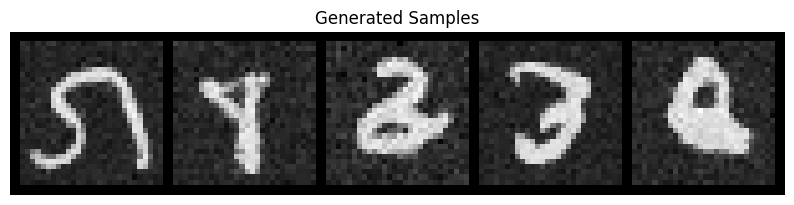

  Step 600/750, Loss: 0.0446
  Step 700/750, Loss: 0.0463

Training - Epoch 37 average loss: 0.0458
Running validation...
Validation - Epoch 37 average loss: 0.0457
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


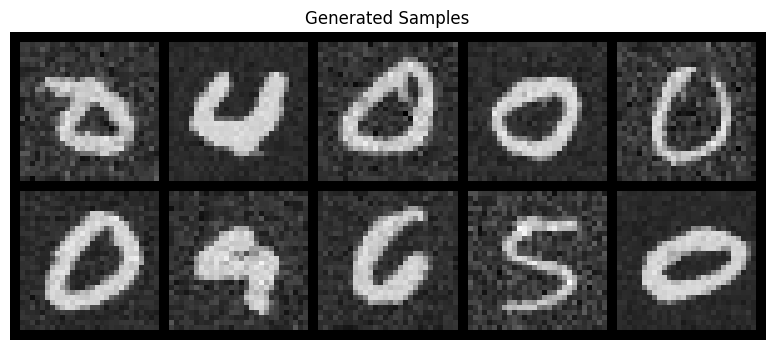

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0457)

Epoch 38/50
--------------------
  Step 0/750, Loss: 0.0405
  Step 100/750, Loss: 0.0412
  Step 200/750, Loss: 0.0358
  Step 300/750, Loss: 0.0435
  Step 400/750, Loss: 0.0459
  Step 500/750, Loss: 0.0437
  Generating samples (EMA model)...


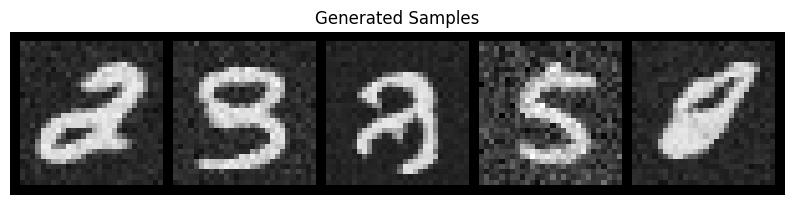

  Step 600/750, Loss: 0.0470
  Step 700/750, Loss: 0.0439

Training - Epoch 38 average loss: 0.0460
Running validation...
Validation - Epoch 38 average loss: 0.0467
Learning rate: 0.000100
No improvement for 1/10 epochs

Epoch 39/50
--------------------
  Step 0/750, Loss: 0.0439
  Step 100/750, Loss: 0.0454
  Step 200/750, Loss: 0.0466
  Step 300/750, Loss: 0.0491
  Step 400/750, Loss: 0.0508
  Step 500/750, Loss: 0.0527
  Generating samples (EMA model)...


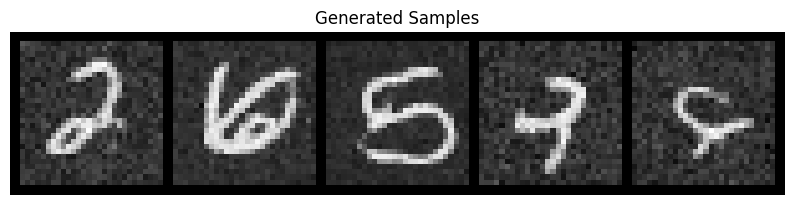

  Step 600/750, Loss: 0.0507
  Step 700/750, Loss: 0.0418

Training - Epoch 39 average loss: 0.0456
Running validation...
Validation - Epoch 39 average loss: 0.0455
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


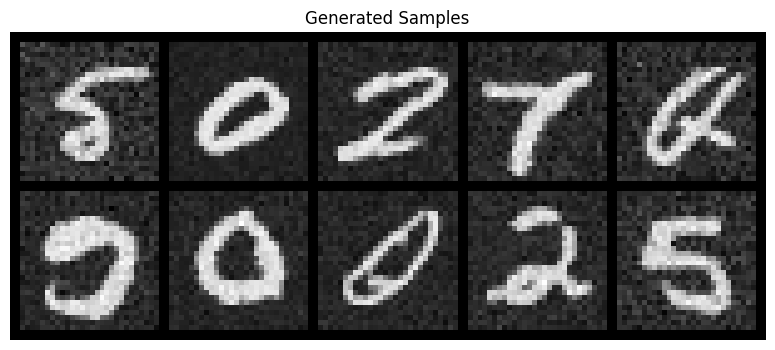

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0455)

Epoch 40/50
--------------------
  Step 0/750, Loss: 0.0497
  Step 100/750, Loss: 0.0507
  Step 200/750, Loss: 0.0393
  Step 300/750, Loss: 0.0399
  Step 400/750, Loss: 0.0445
  Step 500/750, Loss: 0.0426
  Generating samples (EMA model)...


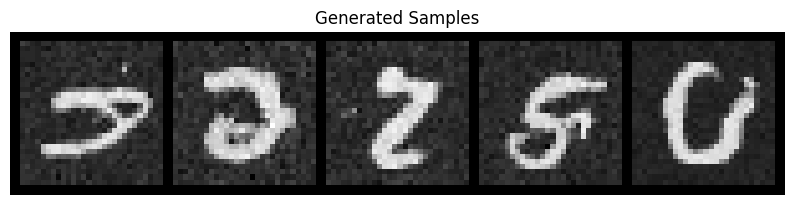

  Step 600/750, Loss: 0.0451
  Step 700/750, Loss: 0.0458

Training - Epoch 40 average loss: 0.0456
Running validation...
Validation - Epoch 40 average loss: 0.0461
Learning rate: 0.000100
No improvement for 1/10 epochs

Epoch 41/50
--------------------
  Step 0/750, Loss: 0.0453
  Step 100/750, Loss: 0.0458
  Step 200/750, Loss: 0.0496
  Step 300/750, Loss: 0.0476
  Step 400/750, Loss: 0.0469
  Step 500/750, Loss: 0.0478
  Generating samples (EMA model)...


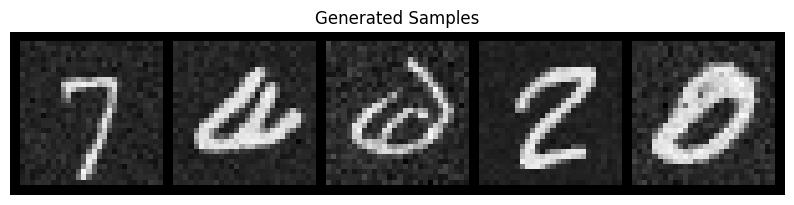

  Step 600/750, Loss: 0.0440
  Step 700/750, Loss: 0.0446

Training - Epoch 41 average loss: 0.0456
Running validation...
Validation - Epoch 41 average loss: 0.0458
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


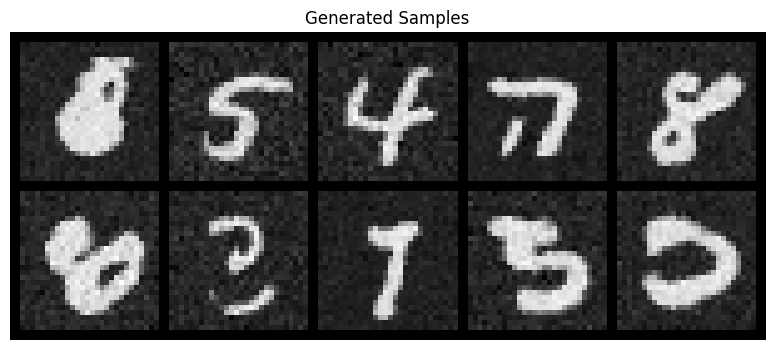

No improvement for 2/10 epochs

Epoch 42/50
--------------------
  Step 0/750, Loss: 0.0453
  Step 100/750, Loss: 0.0422
  Step 200/750, Loss: 0.0469
  Step 300/750, Loss: 0.0430
  Step 400/750, Loss: 0.0505
  Step 500/750, Loss: 0.0518
  Generating samples (EMA model)...


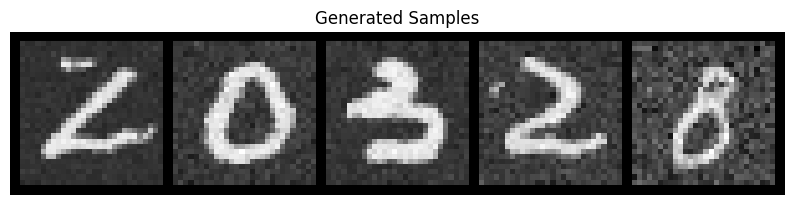

  Step 600/750, Loss: 0.0525
  Step 700/750, Loss: 0.0512

Training - Epoch 42 average loss: 0.0459
Running validation...
Validation - Epoch 42 average loss: 0.0459
Learning rate: 0.000100
No improvement for 3/10 epochs

Epoch 43/50
--------------------
  Step 0/750, Loss: 0.0438
  Step 100/750, Loss: 0.0451
  Step 200/750, Loss: 0.0525
  Step 300/750, Loss: 0.0455
  Step 400/750, Loss: 0.0555
  Step 500/750, Loss: 0.0465
  Generating samples (EMA model)...


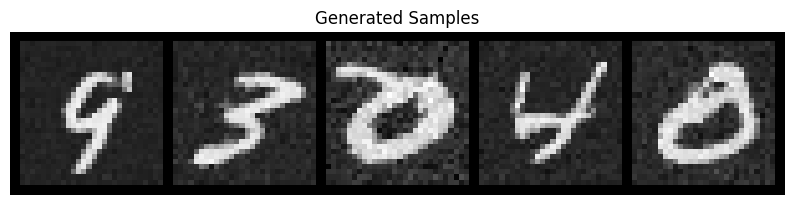

  Step 600/750, Loss: 0.0470
  Step 700/750, Loss: 0.0431

Training - Epoch 43 average loss: 0.0457
Running validation...
Validation - Epoch 43 average loss: 0.0461
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


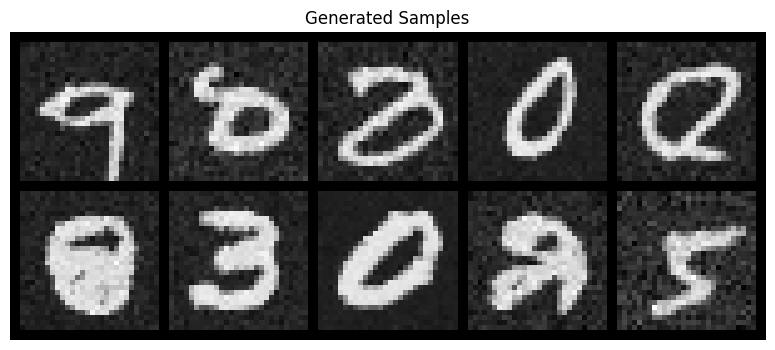

No improvement for 4/10 epochs

Epoch 44/50
--------------------
  Step 0/750, Loss: 0.0484
  Step 100/750, Loss: 0.0448
  Step 200/750, Loss: 0.0498
  Step 300/750, Loss: 0.0480
  Step 400/750, Loss: 0.0391
  Step 500/750, Loss: 0.0480
  Generating samples (EMA model)...


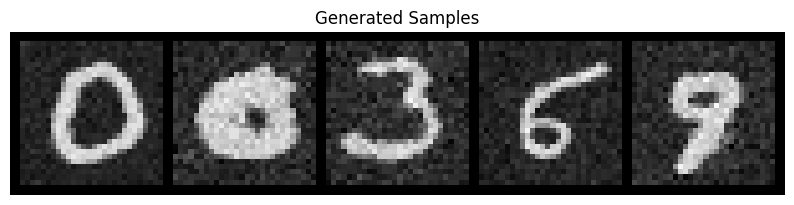

  Step 600/750, Loss: 0.0486
  Step 700/750, Loss: 0.0448

Training - Epoch 44 average loss: 0.0455
Running validation...
Validation - Epoch 44 average loss: 0.0463
Learning rate: 0.000100
No improvement for 5/10 epochs

Epoch 45/50
--------------------
  Step 0/750, Loss: 0.0399
  Step 100/750, Loss: 0.0466
  Step 200/750, Loss: 0.0497
  Step 300/750, Loss: 0.0486
  Step 400/750, Loss: 0.0437
  Step 500/750, Loss: 0.0437
  Generating samples (EMA model)...


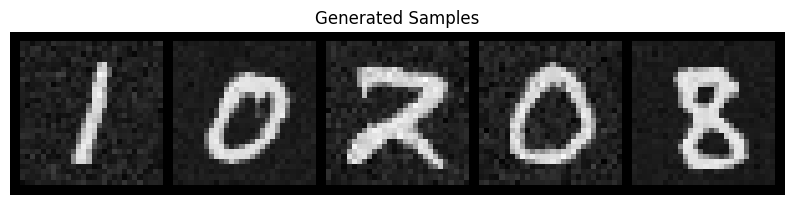

  Step 600/750, Loss: 0.0467
  Step 700/750, Loss: 0.0535

Training - Epoch 45 average loss: 0.0456
Running validation...
Validation - Epoch 45 average loss: 0.0449
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


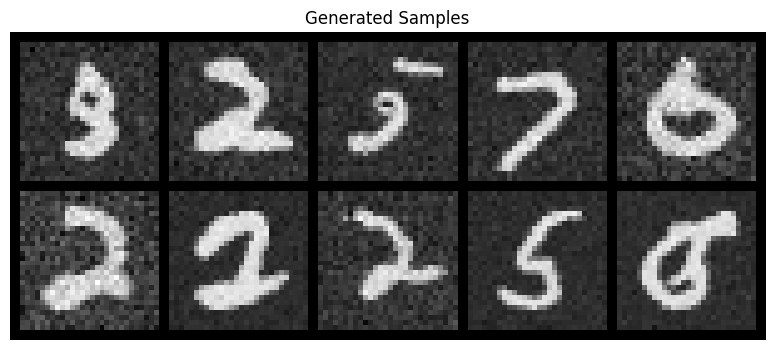

Created backup at best_diffusion_model_ema.pt.backup
Model successfully saved to best_diffusion_model_ema.pt
✓ New best EMA model saved! (Val Loss: 0.0449)

Epoch 46/50
--------------------
  Step 0/750, Loss: 0.0423
  Step 100/750, Loss: 0.0459
  Step 200/750, Loss: 0.0480
  Step 300/750, Loss: 0.0433
  Step 400/750, Loss: 0.0503
  Step 500/750, Loss: 0.0433
  Generating samples (EMA model)...


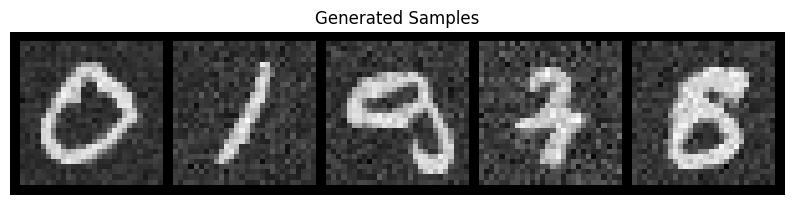

  Step 600/750, Loss: 0.0425
  Step 700/750, Loss: 0.0495

Training - Epoch 46 average loss: 0.0454
Running validation...
Validation - Epoch 46 average loss: 0.0452
Learning rate: 0.000100
No improvement for 1/10 epochs

Epoch 47/50
--------------------
  Step 0/750, Loss: 0.0525
  Step 100/750, Loss: 0.0463
  Step 200/750, Loss: 0.0474
  Step 300/750, Loss: 0.0402
  Step 400/750, Loss: 0.0521
  Step 500/750, Loss: 0.0441
  Generating samples (EMA model)...


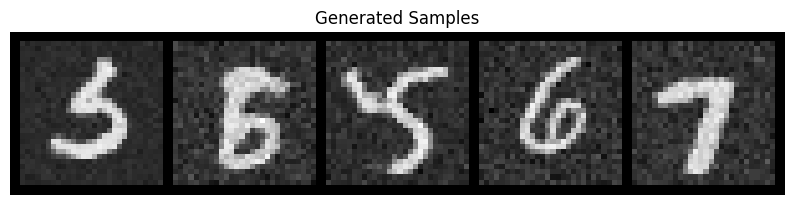

  Step 600/750, Loss: 0.0436
  Step 700/750, Loss: 0.0408

Training - Epoch 47 average loss: 0.0454
Running validation...
Validation - Epoch 47 average loss: 0.0454
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


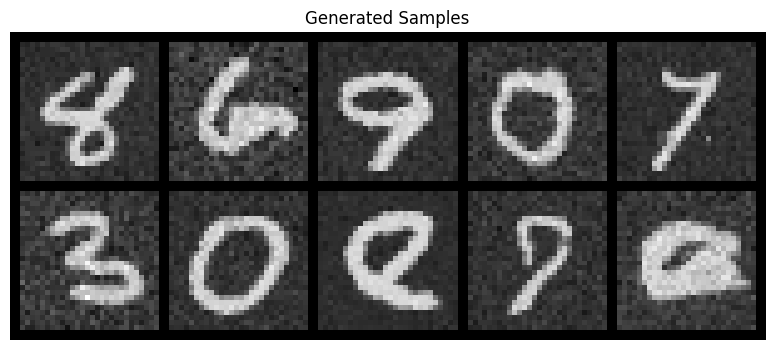

No improvement for 2/10 epochs

Epoch 48/50
--------------------
  Step 0/750, Loss: 0.0498
  Step 100/750, Loss: 0.0466
  Step 200/750, Loss: 0.0490
  Step 300/750, Loss: 0.0493
  Step 400/750, Loss: 0.0408
  Step 500/750, Loss: 0.0550
  Generating samples (EMA model)...


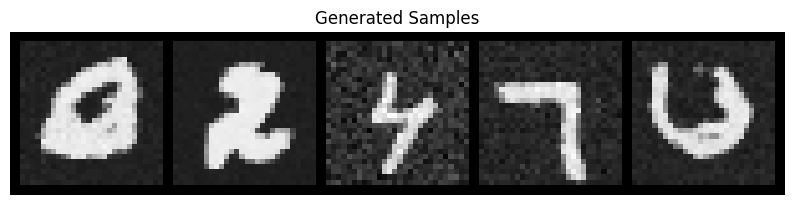

  Step 600/750, Loss: 0.0513
  Step 700/750, Loss: 0.0353

Training - Epoch 48 average loss: 0.0454
Running validation...
Validation - Epoch 48 average loss: 0.0455
Learning rate: 0.000100
No improvement for 3/10 epochs

Epoch 49/50
--------------------
  Step 0/750, Loss: 0.0490
  Step 100/750, Loss: 0.0443
  Step 200/750, Loss: 0.0440
  Step 300/750, Loss: 0.0435
  Step 400/750, Loss: 0.0398
  Step 500/750, Loss: 0.0488
  Generating samples (EMA model)...


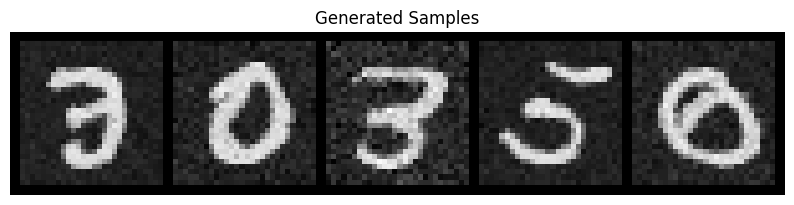

  Step 600/750, Loss: 0.0446
  Step 700/750, Loss: 0.0369

Training - Epoch 49 average loss: 0.0453
Running validation...
Validation - Epoch 49 average loss: 0.0456
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


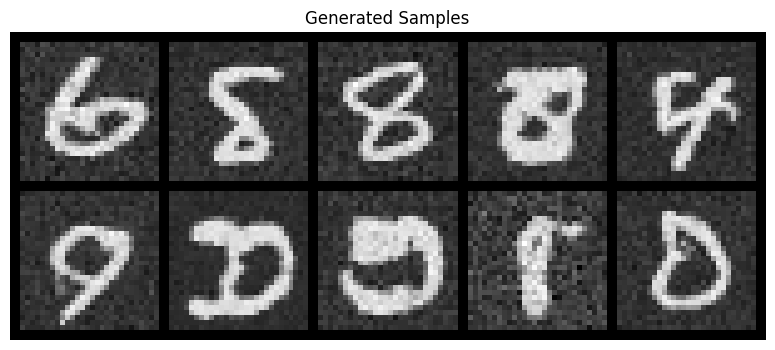

No improvement for 4/10 epochs

Epoch 50/50
--------------------
  Step 0/750, Loss: 0.0513
  Step 100/750, Loss: 0.0481
  Step 200/750, Loss: 0.0449
  Step 300/750, Loss: 0.0444
  Step 400/750, Loss: 0.0410
  Step 500/750, Loss: 0.0424
  Generating samples (EMA model)...


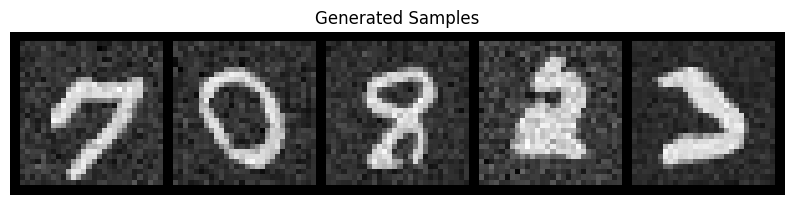

  Step 600/750, Loss: 0.0399
  Step 700/750, Loss: 0.0495

Training - Epoch 50 average loss: 0.0452
Running validation...
Validation - Epoch 50 average loss: 0.0455
Learning rate: 0.000100

Generating samples for visual progress check (EMA model)...


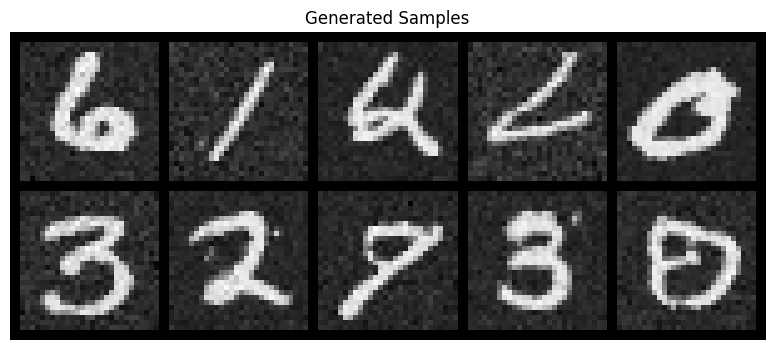

No improvement for 5/10 epochs

TRAINING COMPLETE (WITH EMA)
Best validation loss: 0.0449
Generating final samples (EMA model)...


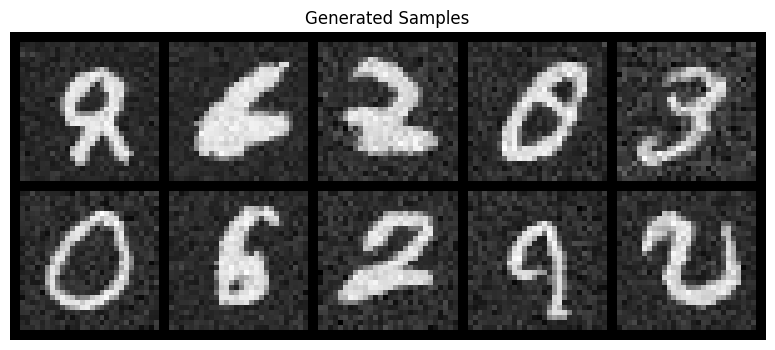

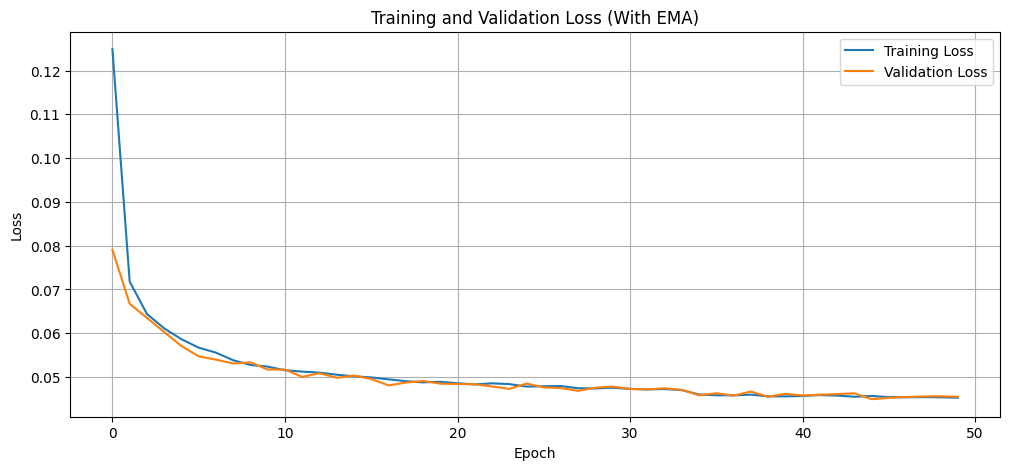

In [21]:
# ------------------------------------------------------------------------------
# Updated code cell: "Implementation of the main training loop" WITH EMA
# ------------------------------------------------------------------------------

##########################################
# 1) CREATE THE EMA MODEL (CLONE OF MAIN MODEL)
##########################################

# Assume you already created your main model above, like:
# model = UNet(
#     T=n_steps, 
#     img_ch=IMG_CH,
#     img_size=IMG_SIZE,
#     down_chs=(32, 64, 128),
#     t_embed_dim=8,
#     c_embed_dim=64  # <-- Suppose your main model uses 64
# ).to(device)

# Create the EMA model with the SAME c_embed_dim=64 as the main model
ema_model = UNet(
    T=n_steps, 
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=(32, 64, 128),  # same down_chs as the main model
    t_embed_dim=8,
    c_embed_dim=64           # <-- Must match the main model exactly
).to(device)

# Initialize its weights to match the main model
ema_model.load_state_dict(model.state_dict())
ema_model.eval()  # EMA model is not trained directly

##############################################
# 2) HELPER FUNCTION TO UPDATE EMA PARAMETERS
##############################################
def update_ema(model, ema_model, decay=0.999):
    """
    Exponential Moving Average update:
      ema_param = decay * ema_param + (1 - decay) * model_param
    """
    with torch.no_grad():
        for param, ema_param in zip(model.parameters(), ema_model.parameters()):
            ema_param.data.mul_(decay)
            ema_param.data.add_((1.0 - decay) * param.data)


# ------------------------------------------------------------------------------
# 3) Training configuration
# ------------------------------------------------------------------------------

EPOCHS = 50                 # or more for better results
early_stopping_patience = 10
gradient_clip_value = 1.0
display_frequency = 100
generate_frequency = 500

best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

print("\n" + "="*50)
print("STARTING TRAINING (WITH EMA)")
print("="*50)
model.train()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 20)
    
    # Training phase
    model.train()
    epoch_losses = []
    
    # Process each batch
    for step, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # 1) Zero out previous gradients
        optimizer.zero_grad()

        # 2) Forward + loss calculation on main model
        loss = train_step(images, labels)

        # 3) Backprop
        loss.backward()
        
        # 4) Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)
        
        # 5) Update main model weights
        optimizer.step()

        # 6) Update EMA model weights after each optimizer step
        update_ema(model, ema_model, decay=0.999)  # Adjust decay as you like

        epoch_losses.append(loss.item())

        # Show progress at regular intervals
        if step % display_frequency == 0:
            print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
            
            # Generate samples occasionally using the EMA model
            if step % generate_frequency == 0 and step > 0:
                print("  Generating samples (EMA model)...")
                generate_samples(ema_model, n_samples=5)

    # End of epoch: compute average training loss
    avg_train_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_train_loss)
    print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")
    
    # Validation phase (using the main model for val_loss, but you could also test ema_model if desired)
    model.eval()
    val_epoch_losses = []
    print("Running validation...")
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Calculate validation loss
            val_loss = train_step(val_images, val_labels)
            val_epoch_losses.append(val_loss.item())
    
    # Calculate average validation loss
    avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
    val_losses.append(avg_val_loss)
    print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {current_lr:.6f}")
    
    # Generate samples at the end of each epoch using the EMA model
    if epoch % 2 == 0 or epoch == EPOCHS - 1:
        print("\nGenerating samples for visual progress check (EMA model)...")
        generate_samples(ema_model, n_samples=10)

    # Save best model based on validation loss
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        # We save the EMA model, since that's what we'll actually sample from
        safe_save_model(ema_model, 'best_diffusion_model_ema.pt', optimizer, epoch, best_loss)
        print(f"✓ New best EMA model saved! (Val Loss: {best_loss:.4f})")
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

    # Early stopping
    if no_improve_epochs >= early_stopping_patience:
        print("\nEarly stopping triggered! No improvement in validation loss.")
        break

# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE (WITH EMA)")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples from the EMA model
print("Generating final samples (EMA model)...")
generate_samples(ema_model, n_samples=10)

# Display final training and validation loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (With EMA)')
plt.legend()
plt.grid(True)
plt.show()

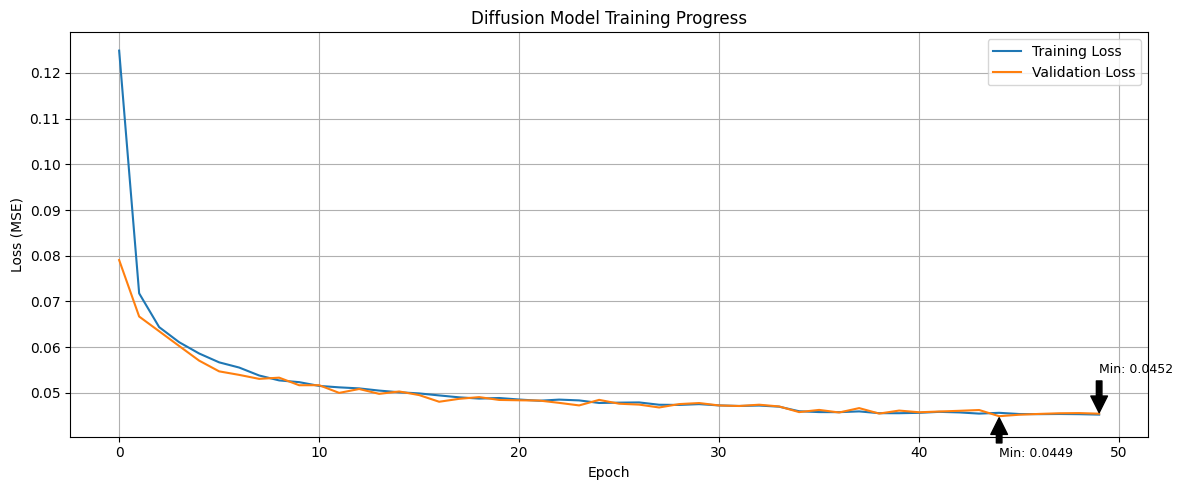


Training Statistics:
------------------------------
Starting training loss:    0.1249
Final training loss:       0.0452
Best training loss:        0.0452
Training loss improvement: 63.8%

Validation Statistics:
------------------------------
Starting validation loss: 0.0791
Final validation loss:    0.0455
Best validation loss:     0.0449


In [22]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}', 
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}', 
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'), 
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")
    
# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss 
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

Generating 4 versions of number 0...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 4 versions of number 1...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 4 versions of number 2...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 4 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 4 versions of number 4...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising ste

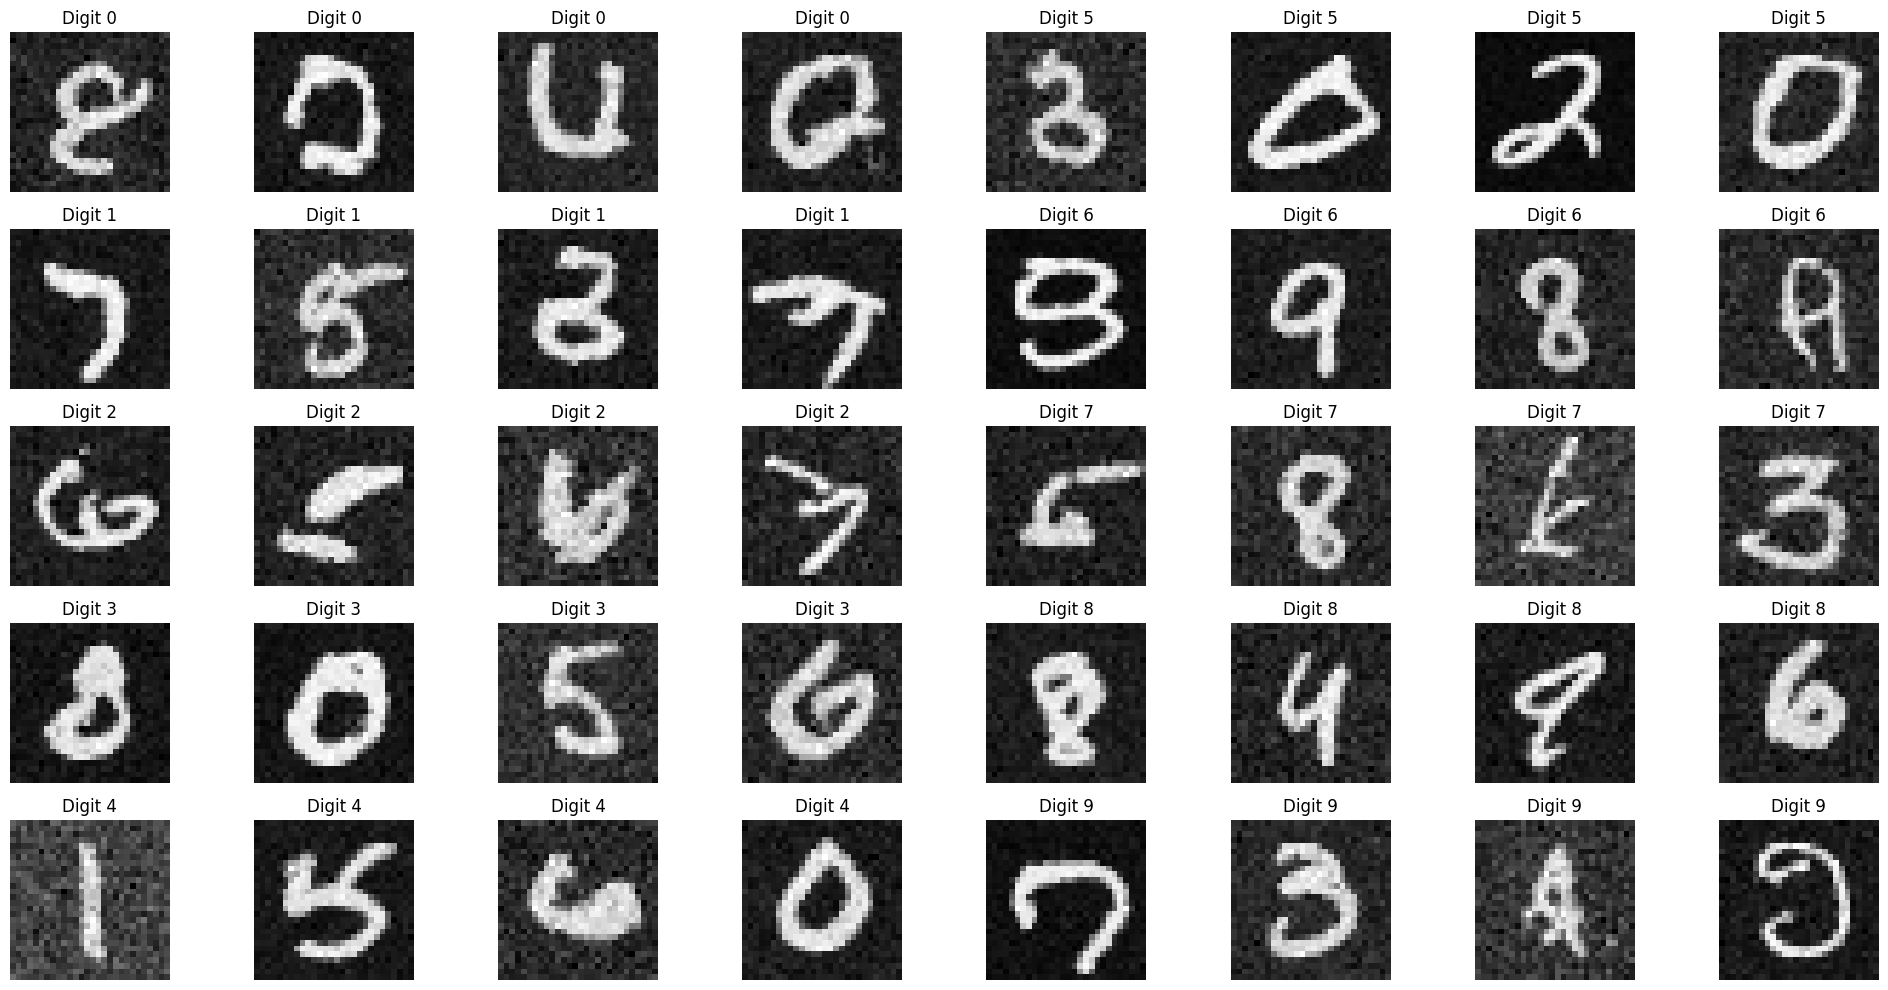


STUDENT ACTIVITY: Generating numbers with different noise seeds
Generating 1 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 1 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 1 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 1 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed
Generating 1 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199

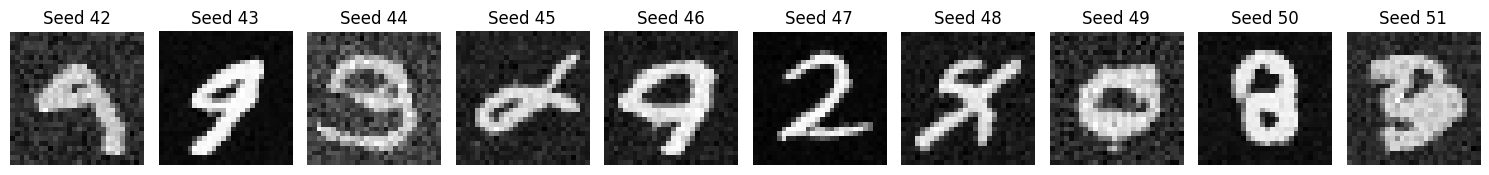

In [23]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.
    
    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate
        
    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")
        
        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)
            
            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(ema_model, i, n_samples=4)
    
    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)
        
        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
            
        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(ema_model, number, n_samples)

# Example: Generate 10 variations of the digit 3 with different seeds and display them
digit = 3
n_variations = 10
plt.figure(figsize=(15, 3))
for i in range(n_variations):
    samples = generate_with_seed(digit, seed_value=42 + i, n_samples=1)
    plt.subplot(1, n_variations, i+1)
    if IMG_CH == 1:
        plt.imshow(samples[0][0].cpu(), cmap='gray')
    else:
        img = samples[0].permute(1, 2, 0).cpu()
        if img.min() < 0:
            img = (img + 1) / 2
        plt.imshow(img)
    plt.title(f"Seed {42 + i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!

In [24]:
print(model)

UNet(
  (time_embed): Sequential(
    (0): SinusoidalPositionEmbedBlock()
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): GELU(approximate='none')
    (5): Unflatten(dim=1, unflattened_size=(8, 1, 1))
  )
  (class_embed): EmbedBlock(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): GELU(approximate='none')
      (4): Unflatten(dim=1, unflattened_size=(64, 1, 1))
    )
  )
  (init_conv): GELUConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
    )
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (conv_blocks): Sequential(
        (0): GELUConvBlock(
          (model): Sequentia


Generating number 0:


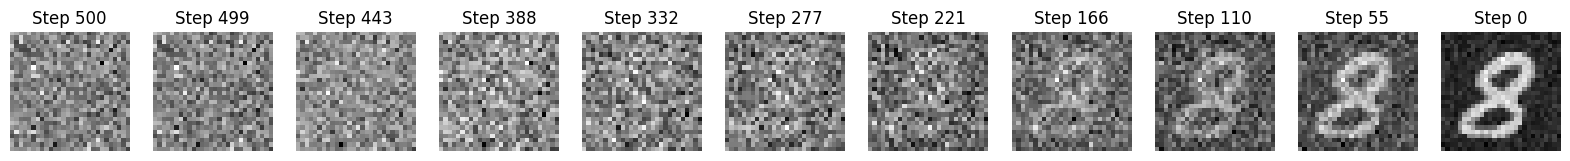


Generating number 3:


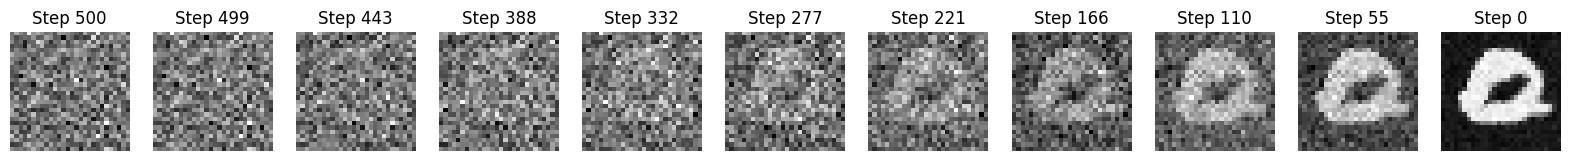


Generating number 7:


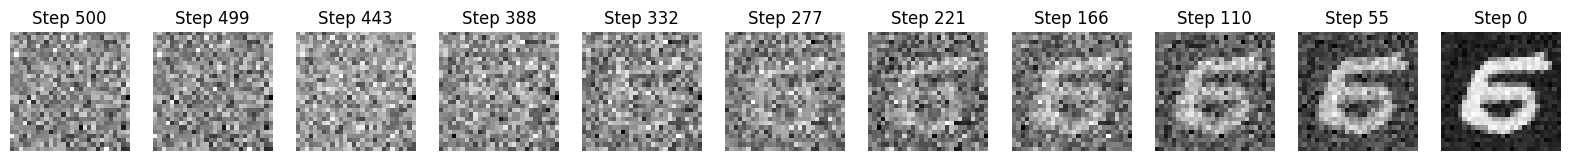

In [25]:
def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Show how an image evolves from noise to a clear number
    """
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up which number to generate
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones((c_one_hot.size(0), 1), device=device)

        # Calculate which steps to show
        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()

        # Store images for visualization
        images = []
        images.append(x[0].cpu())

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            if t in steps_to_show:
                images.append(x[0].cpu())

        # Show the progression
        plt.figure(figsize=(20, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img = img.permute(1, 2, 0)
                if img.min() < 0:
                    img = (img + 1) / 2
                plt.imshow(img)
            step = n_steps if i == 0 else steps_to_show[i-1]
            plt.title(f'Step {step}')
            plt.axis('off')
        plt.show()

# Show generation process for a few numbers
for number in [0, 3, 7]:
    print(f"\nGenerating number {number}:")
    visualize_generation_steps(ema_model, number)

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [26]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # For local use, install CLIP and dependencies in your terminal, not here:
    # pip install ftfy regex tqdm
    # pip install git+https://github.com/openai/CLIP.git

    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("To install CLIP, run in your terminal:")
    print("pip install ftfy regex tqdm")
    print("pip install git+https://github.com/openai/CLIP.git")
    print("After installing, restart your notebook kernel.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F

Setting up CLIP (Contrastive Language-Image Pre-training) model...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [27]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.
    
    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
Generating 4 versions of number 0...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


/var/folders/m_/nqk8g4cs5tz8t1yj2kglt8p80000gn/T/ipykernel_50915/2409073262.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/Users/martin.demel/myenv3.10/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


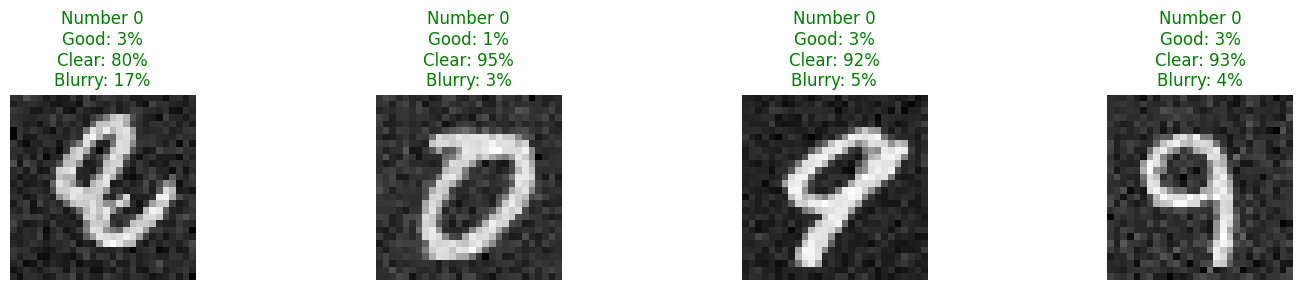


Generating and evaluating number 1...
Generating 4 versions of number 1...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


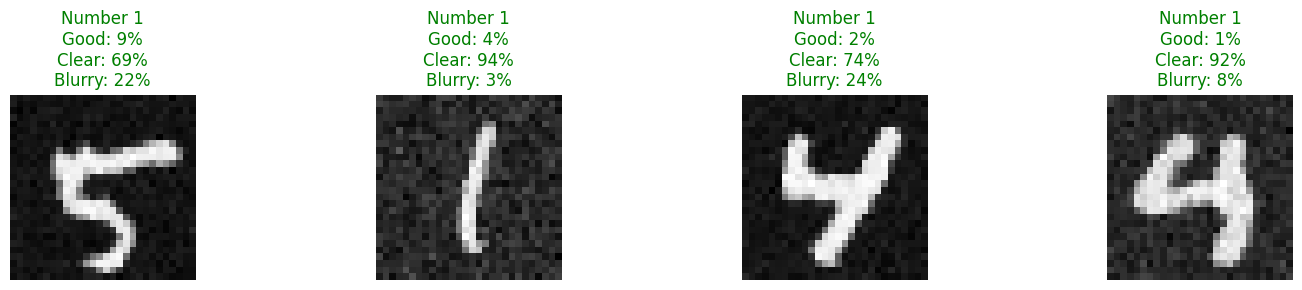


Generating and evaluating number 2...
Generating 4 versions of number 2...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


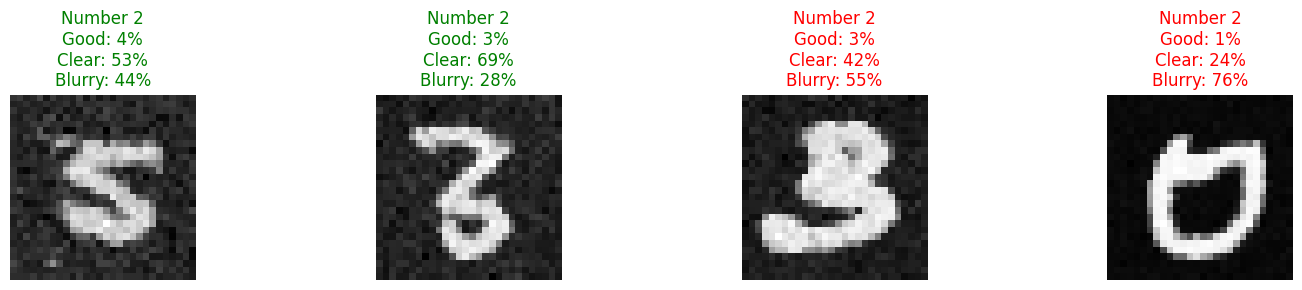


Generating and evaluating number 3...
Generating 4 versions of number 3...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


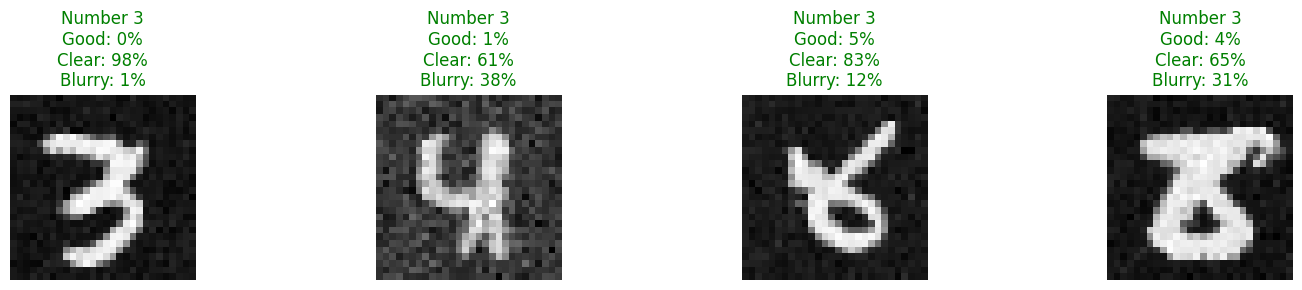


Generating and evaluating number 4...
Generating 4 versions of number 4...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


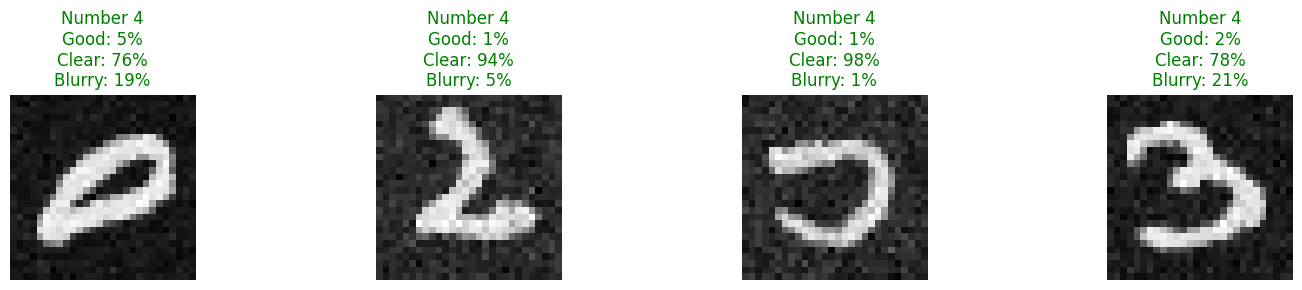


Generating and evaluating number 5...
Generating 4 versions of number 5...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


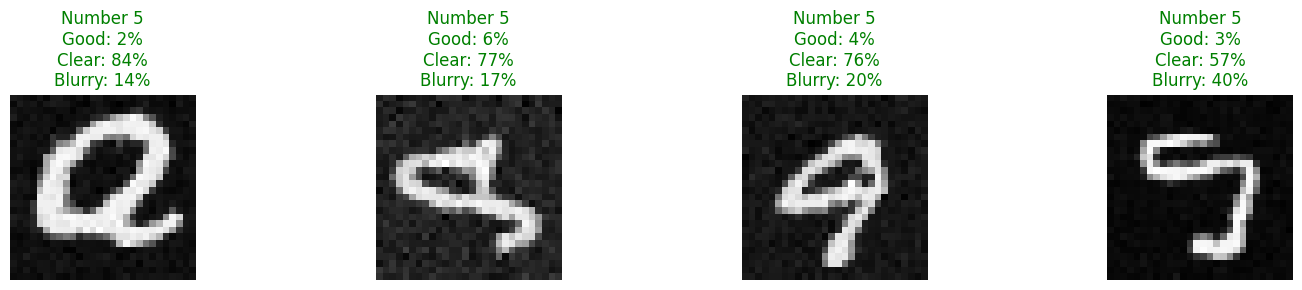


Generating and evaluating number 6...
Generating 4 versions of number 6...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


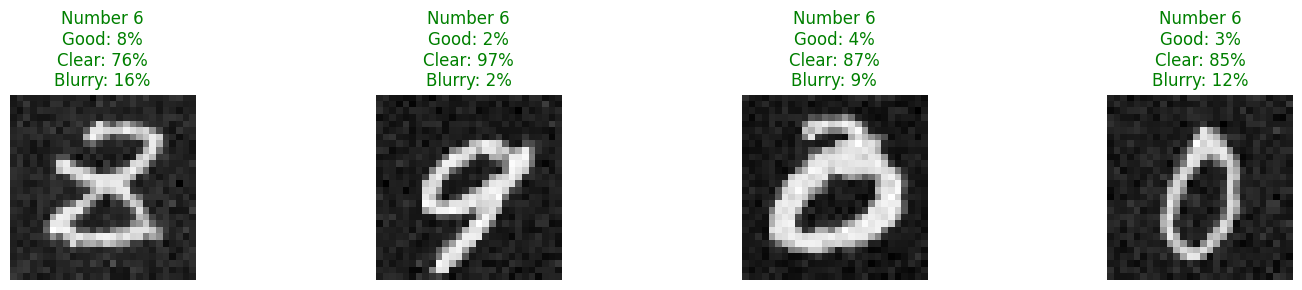


Generating and evaluating number 7...
Generating 4 versions of number 7...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


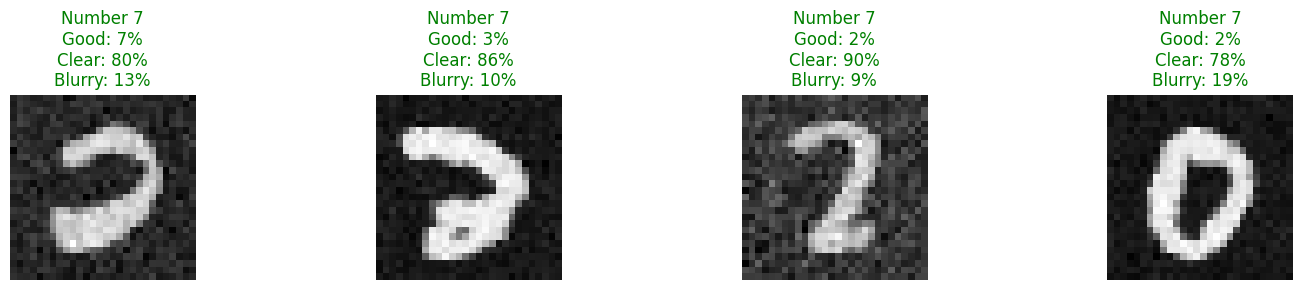


Generating and evaluating number 8...
Generating 4 versions of number 8...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


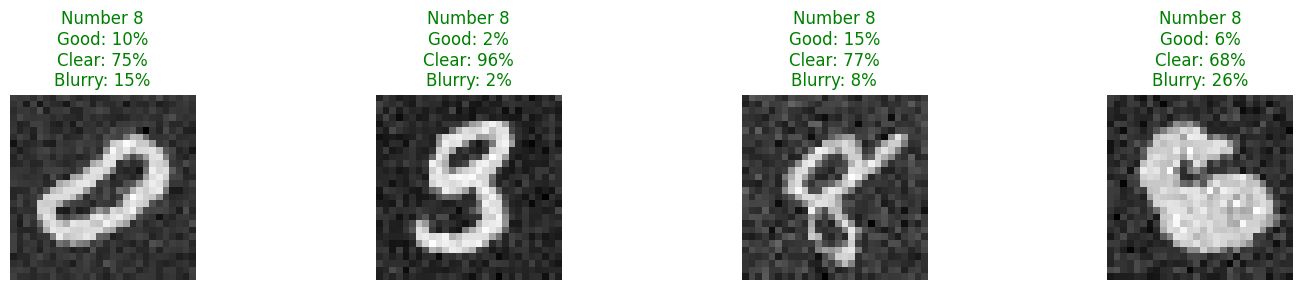


Generating and evaluating number 9...
Generating 4 versions of number 9...
  Denoising step 99/499 completed
  Denoising step 199/499 completed
  Denoising step 299/499 completed
  Denoising step 399/499 completed
  Denoising step 499/499 completed


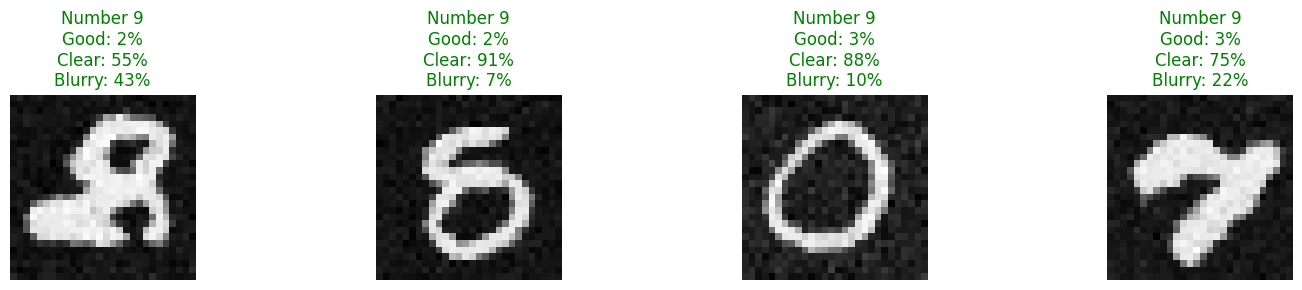


STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10) 
# similarities = evaluate_with_clip(samples, digit)
# 
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#   

In [28]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.
    
    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed
    
    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality
    
    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)
        
    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3
    
    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []
            
            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]
                
                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)
                
                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()
            
            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)
    
    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.
    
    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings
    
    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.
    
    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent
        
    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:
        
        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images
        
        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range
        
        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224), 
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity
        
    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()
            
            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3
            
            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")
            
            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)
            
            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)
        
        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")
        
        # Generate 4 different variations of the current digit
        samples = generate_number(ema_model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))
        
        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)
            
            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'
            
            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%', 
                      color=title_color)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks
        
        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()
    
    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10) 
# similarities = evaluate_with_clip(samples, digit)
# 
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion 
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture 
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model 

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process? 

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with 
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges